In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
import seaborn as sns
from IPython.display import display, HTML
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import umap
from umap import UMAP

# Analysis

## Statistic metrics

In [167]:
names = ["RMS_22", "Esum22", "EnGrow", "Emax_track", "EsumCC2", "sum01", "sum02",
 "sum03", "EmaxСС2", "E3_track", "E_track", "RMS_1", "RMS_max", "Esum_S4",
  "Emax_S4", "Esum_S3", "Emax_S3", "Emax_left_BDK", "Esum_left_BDK", "Emax_front_BDK",
   "Esum_front_BDK", "Emax_right_BDK", "Esum_right_BDK", "Emax_back_BDK", "Esum_back_BDK",
    "hitsum", "hit1", "transversal", "longitudinal", "Number_points_track", "Label"]


prot = pd.read_csv('./data/proton.txt', delimiter='\s+', header=None)
elec = pd.read_csv('./data/electron.txt', delimiter='\s+', header=None)
# prot['Label'] = 0
# elec['Label'] = 1
prot['Label'] = 1
elec['Label'] = 0
df = pd.concat([prot, elec], ignore_index=True)
# drop columns with observation number 
df.drop(columns=30, inplace=True)
df = df.set_axis(names, axis=1)
describe = df.describe()
# .apply("{0:.2f}".format)
describe.drop(columns='Label',inplace=True)
describe.drop(['count', '25%', '50%', '75%'],inplace=True)
# describe.apply("{0:.2f}".format)
describe = describe.applymap(lambda x: f"{x:0.2f}")
describe = describe.transpose
describe.to_csv("describe.csv", encoding='utf-8')

/var/folders/y5/dqknd6mj4l965pqd1q8tspvm0000gn/T/ipykernel_50034/3134398973.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe = describe.applymap(lambda x: f"{x:0.2f}")


In [59]:
prot.shape

(998, 32)

In [67]:
elec.shape

(7902, 32)

In [66]:
df.shape

(8900, 31)

### Split to train and test (should not be here)

In [168]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

#### Check for numbers in train and test samples

In [207]:
var = pd.DataFrame(X_train)
var['Label'] = y_train
print(len(var))
print(f'train sample - {len(var[var.Label == 1])} - elec, {len(var[var.Label == 0])} - prot')

var = pd.DataFrame(X_test)
var['Label'] = y_test
print(len(var))
print(f'test sample - {len(var[var.Label == 1])} - elec, {len(var[var.Label == 0])} - prot')

7120
train sample - 798 - elec, 6322 - prot
1780
test sample - 200 - elec, 1580 - prot


In [61]:
X_train_cutted = np.delete(X_train, obj=[28, 29, 19, 23], axis=1)
X_test_cutted = np.delete(X_test, obj=[28, 29, 19, 23], axis=1)

In [110]:
X_test.shape

(1780, 30)

## PCA Analysis

[2.99377130e-01 1.44194578e-01 8.64117106e-02 7.31027220e-02
 6.34980964e-02 5.94664981e-02 5.20033211e-02 4.26593289e-02
 3.70811325e-02 2.94582889e-02 2.69021802e-02 2.46058820e-02
 1.64718805e-02 1.22654620e-02 8.61653394e-03 7.22054956e-03
 4.80070230e-03 2.24682548e-03 2.02607086e-03 1.72485690e-03
 1.44511795e-03 1.25387386e-03 1.11280601e-03 7.94370001e-04
 6.22579724e-04 3.06652547e-04 2.36771311e-04 9.08951073e-05
 3.14464241e-06 3.87507303e-08]


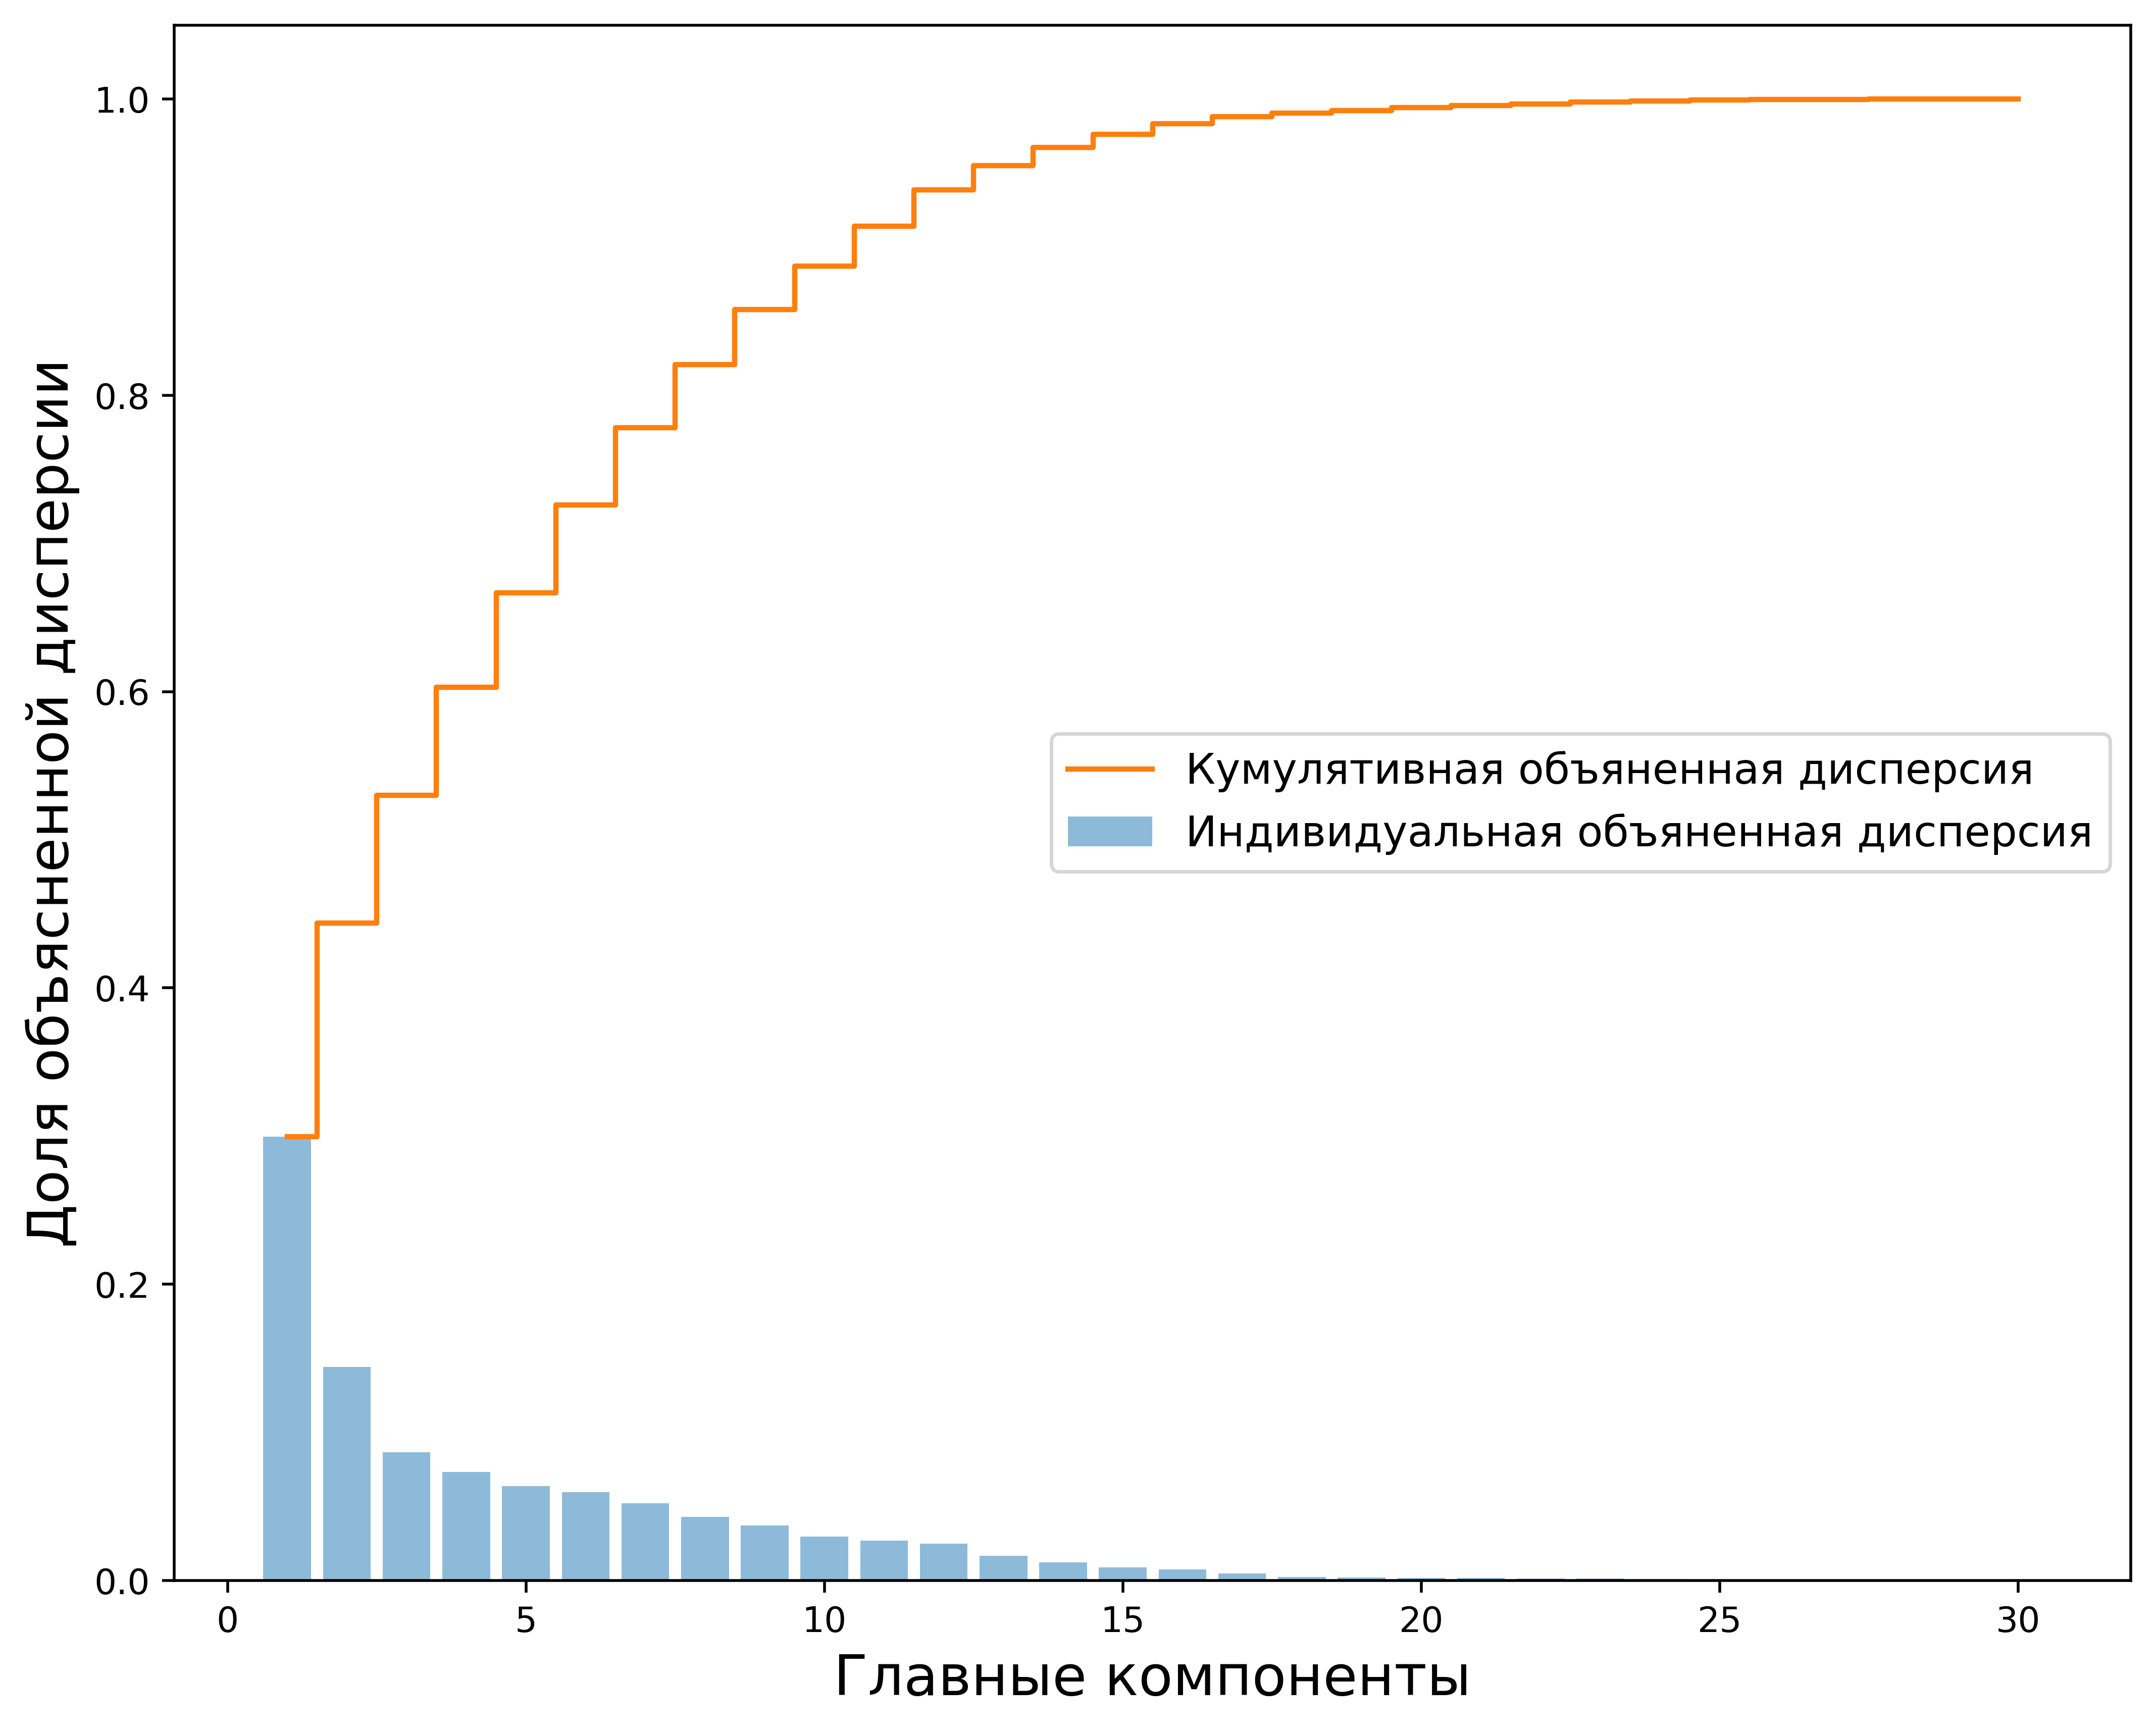

In [184]:
pca = PCA()
X_train_std_pca = pca.fit_transform(X_train_std)
print(pca.explained_variance_ratio_)
fig = plt.figure(figsize=(10,8), dpi=500)
bar = plt.bar(range(1, 31), pca.explained_variance_ratio_, alpha=0.5, align='center', label = "Индивидуальная объяненная дисперсия", color = sns.color_palette()[0])
step = plt.step(range(1, 31), np.cumsum(pca.explained_variance_ratio_), where='mid', label = 'Кумулятивная объяненная дисперсия', color = sns.color_palette()[1])
plt.ylabel('Доля объясненной дисперсии', fontsize=16)
plt.xlabel('Главные компоненты', fontsize=16)
plt.legend(fontsize= 12, loc='center right')
plt.show()

In [246]:
np.cumsum(pca.explained_variance_ratio_)

array([0.30019767, 0.43999616, 0.52169426, 0.59528288, 0.66138702,
       0.72097714, 0.77362777, 0.81639899, 0.85282911, 0.88261095,
       0.90897621, 0.93346915, 0.95005288, 0.96287091, 0.9715644 ,
       0.97867768, 0.98447619, 0.98934062, 0.99191636, 0.99413413,
       0.9956689 , 0.9971129 , 0.99815872, 0.99882918, 0.99936941,
       0.99966057, 0.99989887, 0.9999972 , 0.99999995, 1.        ])

## Random foresr feature reduction analysis

30
 1) Esum22     0.193443
 2) Esum_right_BDK 0.154865
 3) Emax_right_BDK 0.136266
 4) RMS_22     0.075420
 5) hitsum     0.057970
 6) sum03      0.051631
 7) sum02      0.034753
 8) Emax_track 0.030304
 9) RMS_1      0.030152
10) EmaxСС2    0.028199
11) E_track    0.027447
12) E3_track   0.021468
13) sum01      0.020036
14) transversal 0.019789
15) Esum_S3    0.014235
16) RMS_max    0.014191
17) EnGrow     0.011806
18) Emax_S3    0.010341
19) Esum_S4    0.009907
20) Esum_left_BDK 0.009701
21) EsumCC2    0.008942
22) Emax_left_BDK 0.008236
23) hit1       0.008161
24) Emax_S4    0.007040
25) Esum_back_BDK 0.004106
26) Esum_front_BDK 0.003262
27) Emax_back_BDK 0.002874
28) Emax_front_BDK 0.002770
29) Number_points_track 0.001571
30) longitudinal 0.001114


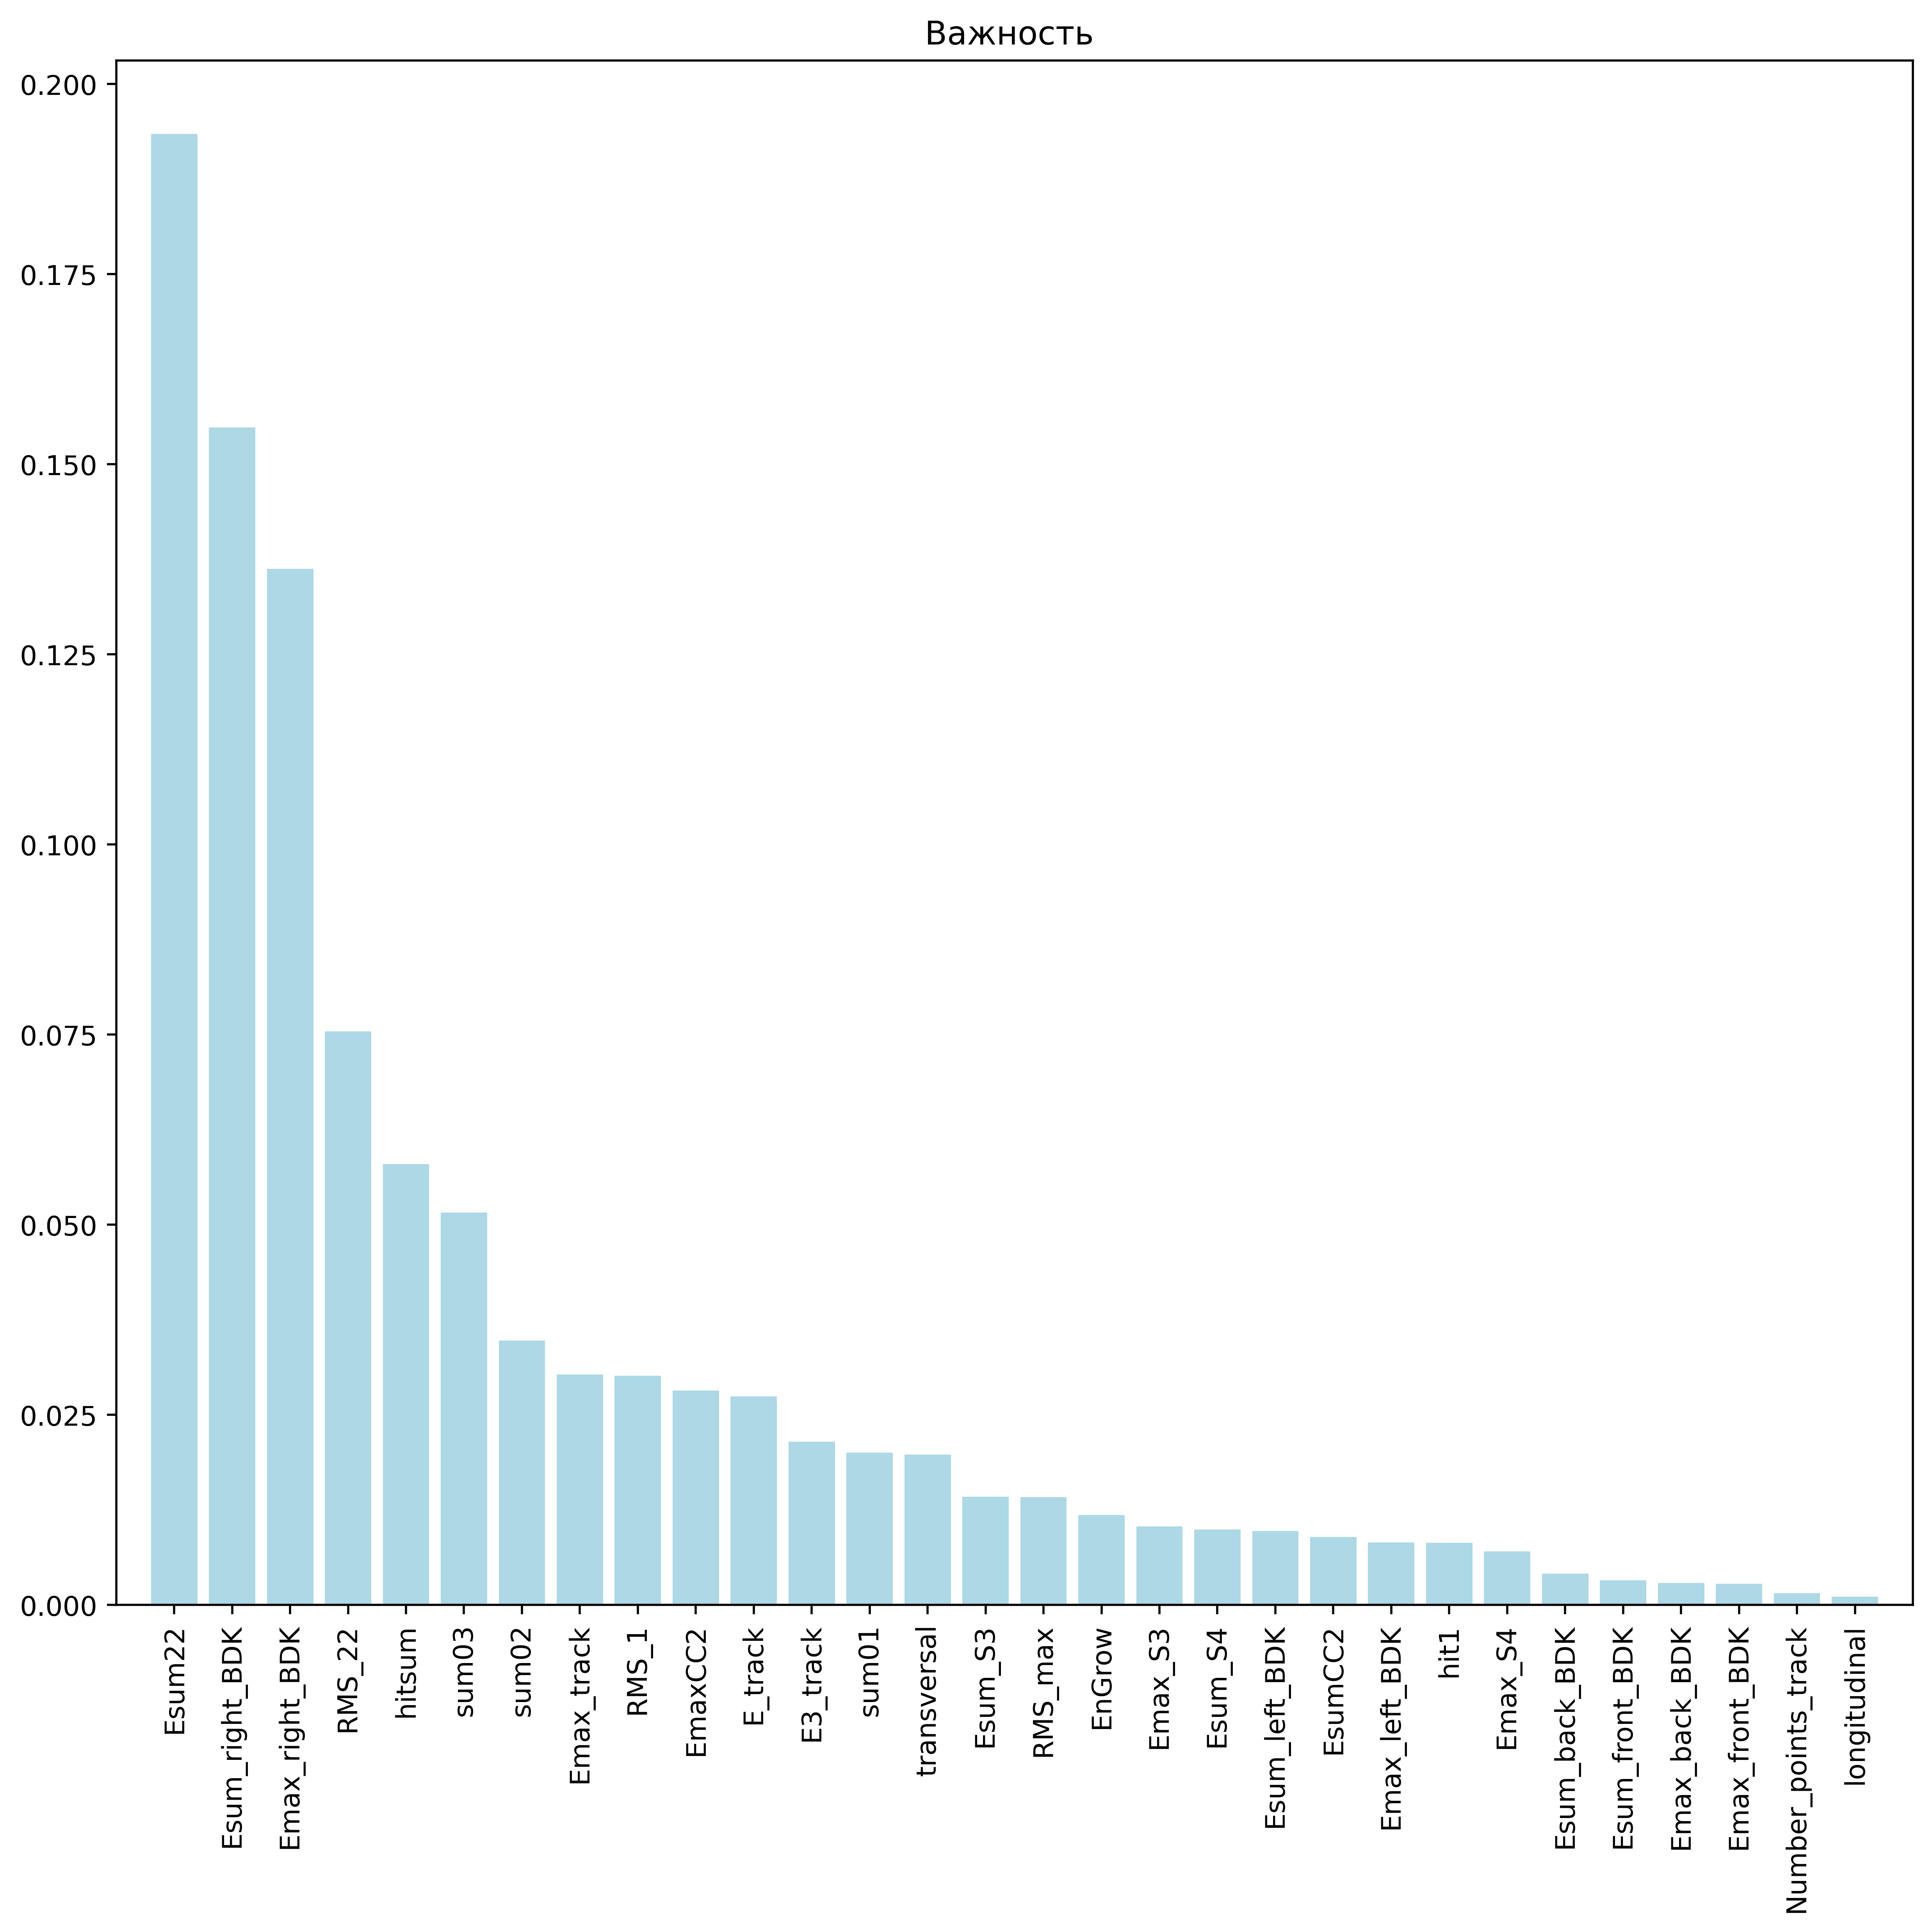

In [63]:
forest = RandomForestClassifier(n_estimators=10000,
                                n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_


30
 1) Esum22     0.193443
 2) Esum_right_BDK 0.154865
 3) Emax_right_BDK 0.136266
 4) RMS_22     0.075420
 5) hitsum     0.057970
 6) sum03      0.051631
 7) sum02      0.034753
 8) Emax_track 0.030304
 9) RMS_1      0.030152
10) EmaxСС2    0.028199
11) E_track    0.027447
12) E3_track   0.021468
13) sum01      0.020036
14) transversal 0.019789
15) Esum_S3    0.014235
16) RMS_max    0.014191
17) EnGrow     0.011806
18) Emax_S3    0.010341
19) Esum_S4    0.009907
20) Esum_left_BDK 0.009701
21) EsumCC2    0.008942
22) Emax_left_BDK 0.008236
23) hit1       0.008161
24) Emax_S4    0.007040
25) Esum_back_BDK 0.004106
26) Esum_front_BDK 0.003262
27) Emax_back_BDK 0.002874
28) Emax_front_BDK 0.002770
29) Number_points_track 0.001571
30) longitudinal 0.001114


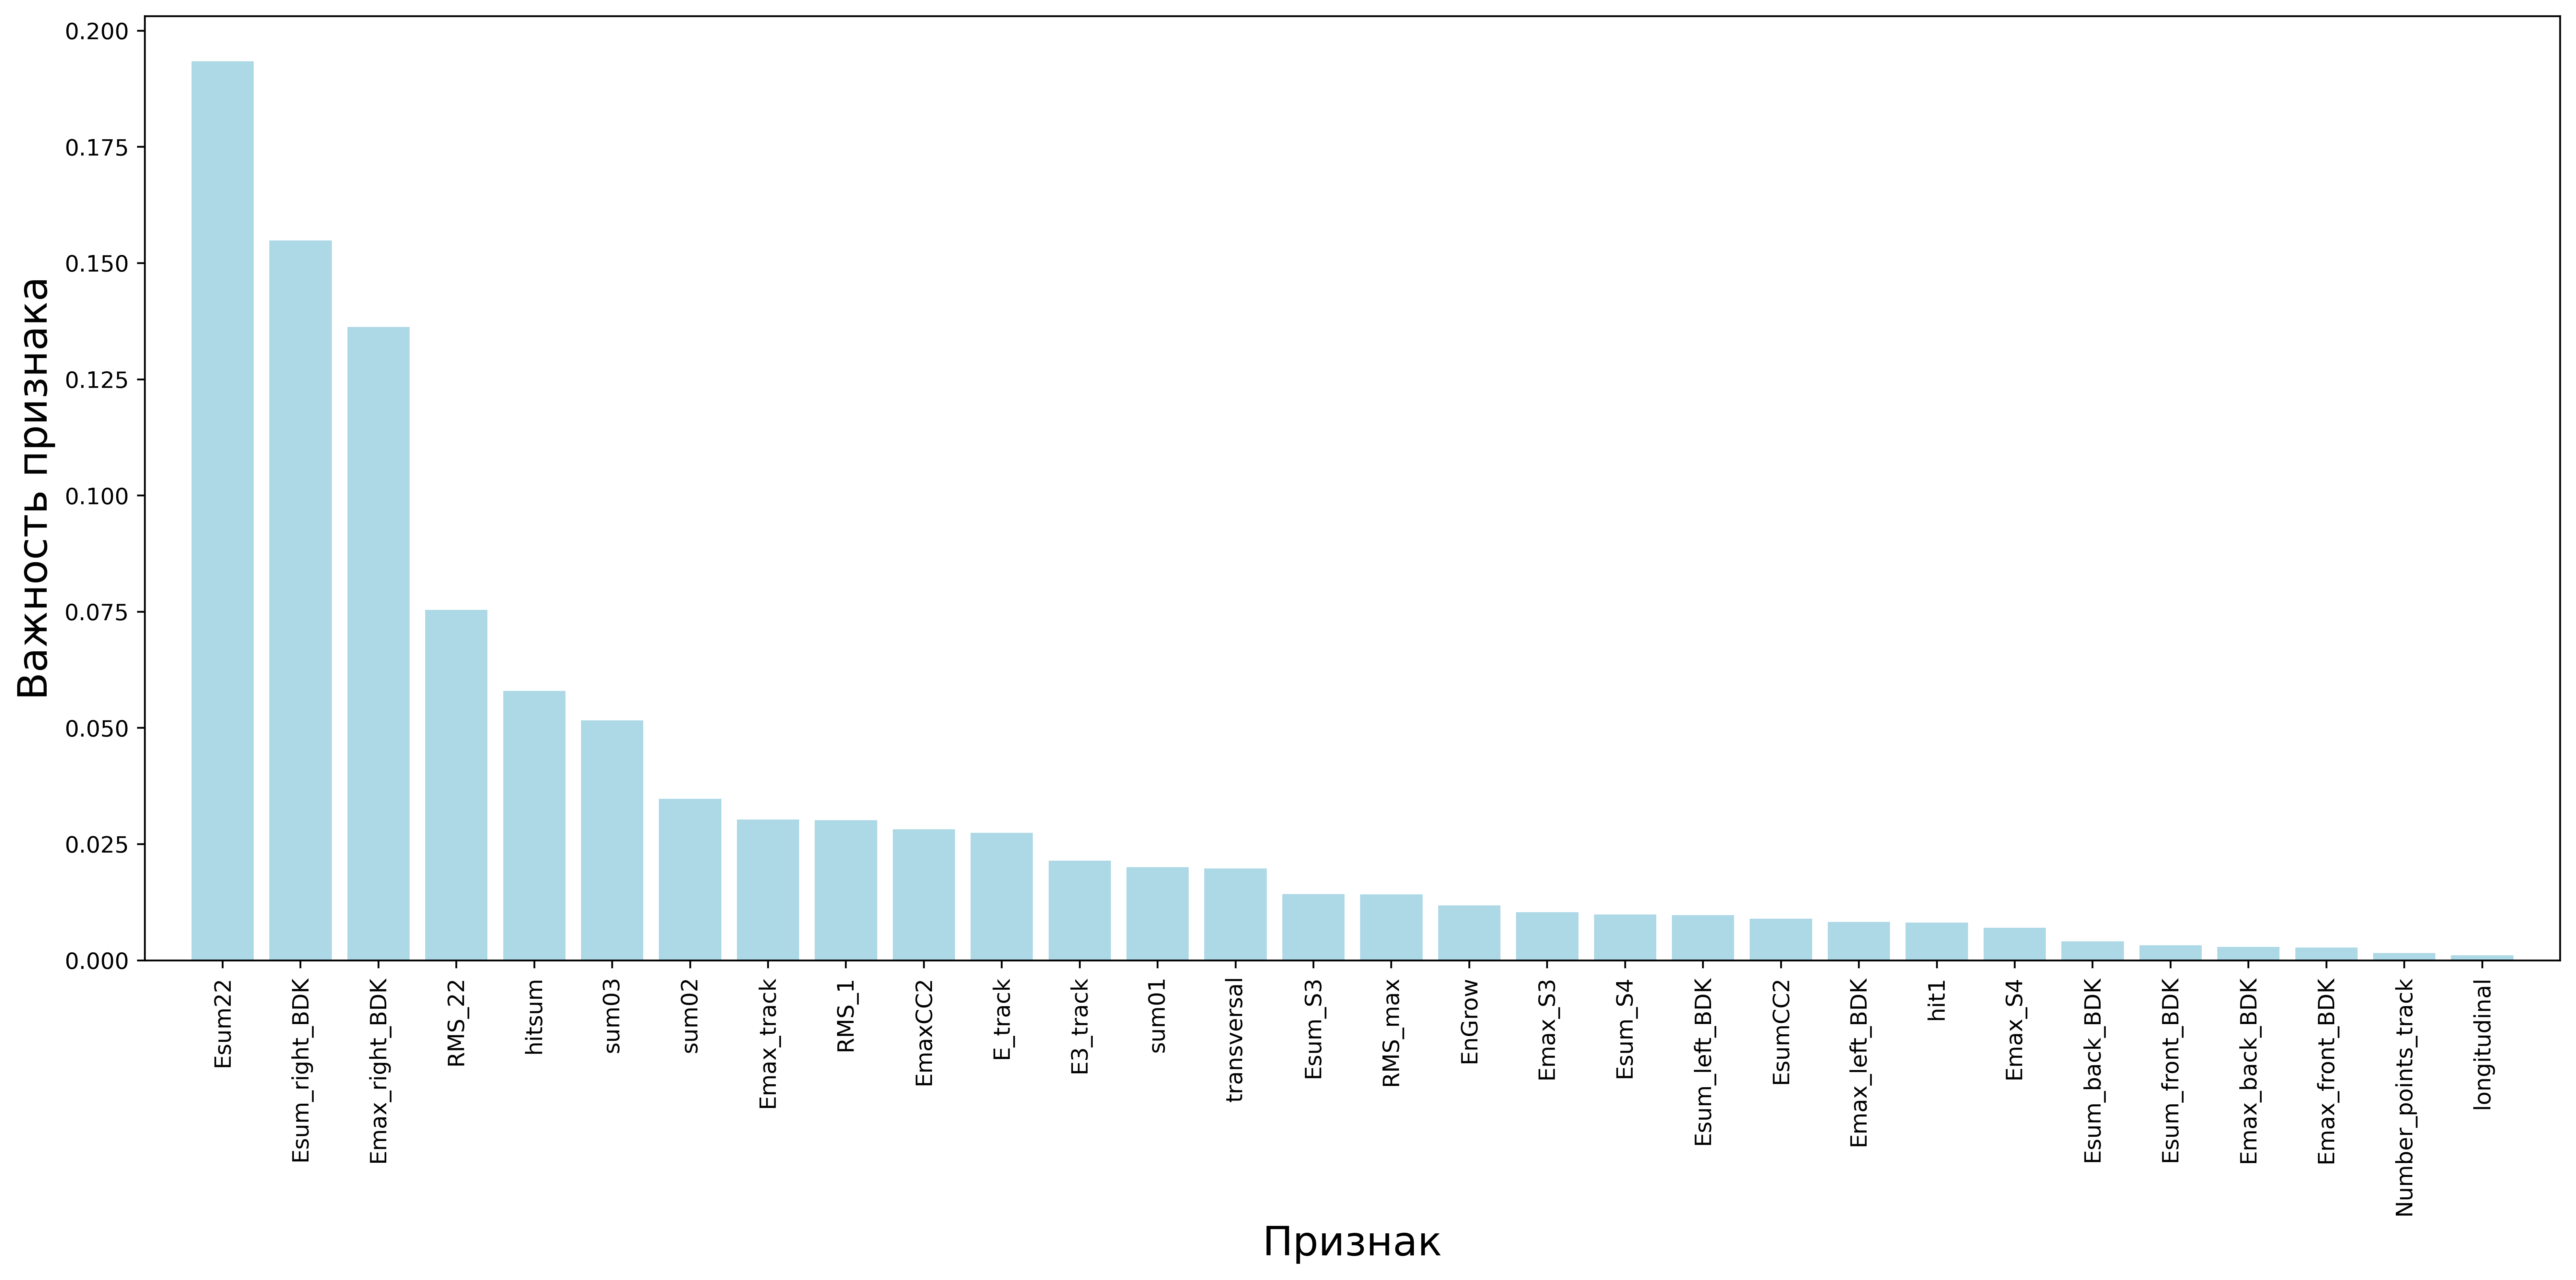

In [208]:

fig = plt.figure(figsize=(16, 8), dpi=500)
indices = np.argsort(importances)[::-1]
feat_labels = df.columns[:-1]
print(X_train.shape[1])
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 10, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.ylabel('Важность признака', fontsize = 18)
plt.xlabel('Признак', fontsize = 18)
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

In [164]:
np.cumsum(importances)

array([0.08150146, 0.27197857, 0.28474041, 0.31641682, 0.32570973,
       0.34256889, 0.37771146, 0.42927067, 0.45893467, 0.48313225,
       0.51149498, 0.53927154, 0.5531384 , 0.5644299 , 0.57228982,
       0.58701178, 0.59808009, 0.60595634, 0.61577521, 0.61891472,
       0.62266324, 0.75542583, 0.90951129, 0.91199013, 0.91597943,
       0.97172466, 0.97911454, 0.99768455, 0.99880421, 1.        ])

# [TEST MODEL] pipeline scaler + pca + logit with optimize

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import make_scorer

In [14]:
pipe_logit = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=16)),
                    ('logit', LogisticRegression(max_iter=500))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'logit__C': param_range}]
scorer = make_scorer(f1_score)
gs = GridSearchCV(estimator=pipe_logit, 
                  param_grid=param_grid, 
                  cv=5,
                  scoring=scorer,
                  n_jobs=-1)


In [167]:
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.991 +/- 0.002


In [16]:
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9529018564160812
{'logit__C': 10.0}


In [ ]:
pipe_logit = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=16)),
                    ('logit', LogisticRegression(max_iter=500, C=10))])
pipe_logit.fit(X_train, y_train)
pipe_logit.score(X_test, y_test)

0.9926966292134831

In [ ]:
logreg = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=16)),
                    ('logit', LogisticRegression(max_iter=500, C=10))])
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
f1_score(y_true=y_test, y_pred=pred)

0.9949431099873578

## Self fold algo (deprecated, skip this step)

In [169]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5).split(X_train, y_train)

metrics_k_fold = {
    "accuracy" : [],
    "f1" : [],
    "precision" : [],
    "recall" : [],
    "roc_auc" : [],
    "params" : []
}
scores = []
params = []
for k, (train, test) in enumerate(kfold):
    gs.fit(X_train[train], y_train[train])
    score = gs.score(X_train[test], y_train[test])
    print(gs.best_params_)
    print(accuracy_score(y_true=y_train[test], y_pred=gs.predict(X_train[test])))
    print(f1_score(y_true=y_train[test], y_pred=gs.predict(X_train[test])))
    print(precision_score(y_true=y_train[test], y_pred=gs.predict(X_train[test])))
    print(recall_score(y_true=y_train[test], y_pred=gs.predict(X_train[test])))
    print(roc_auc_score(y_true=y_train[test], y_score=gs.predict_proba(X_train[test])[:,1]))
    scores.append(score)
    metrics_k_fold["accuracy"].append(accuracy_score(y_true=y_train[test], y_pred=gs.predict(X_train[test])))
    metrics_k_fold["f1"].append(f1_score(y_true=y_train[test], y_pred=gs.predict(X_train[test])))
    metrics_k_fold["precision"].append(precision_score(y_true=y_train[test], y_pred=gs.predict(X_train[test])))
    metrics_k_fold["recall"].append(recall_score(y_true=y_train[test], y_pred=gs.predict(X_train[test])))
    metrics_k_fold["roc_auc"].append(roc_auc_score(y_true=y_train[test], y_score=gs.predict_proba(X_train[test])[:,1]))
    metrics_k_fold["params"].append(gs.best_params_)

    
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %f +/- %.3f' % (np.mean(scores), np.std(scores)))


{'logit__C': 10.0}
0.9887640449438202
0.9490445859872612
0.9612903225806452
0.9371069182389937
0.9972307156884679
Fold: 1, Class dist.: [5057  639], Acc: 0.949
{'logit__C': 10.0}
0.9915730337078652
0.9622641509433962
0.9622641509433962
0.9622641509433962
0.9994481318517414
Fold: 2, Class dist.: [5057  639], Acc: 0.962
{'logit__C': 100.0}
0.9901685393258427
0.9554140127388535
0.974025974025974
0.9375
0.9865382713607596
Fold: 3, Class dist.: [5058  638], Acc: 0.955
{'logit__C': 10.0}
0.9929775280898876
0.9693251533742331
0.9518072289156626
0.9875
0.992998417721519
Fold: 4, Class dist.: [5058  638], Acc: 0.969
{'logit__C': 100.0}
0.9894662921348315
0.9523809523809523
0.967741935483871
0.9375
0.9982397151898734
Fold: 5, Class dist.: [5058  638], Acc: 0.952

CV accuracy: 0.957686 +/- 0.007


# Search best with permutations

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [13]:
input_data_names = [
    "",
    "cutted"
]
standard_names = [
    "",
    "standard"
]
reduce_names = [
    "",
    "pca",
    "umap"
]
classificator_names = [
    "knn",
    "logreg",
    "tree",
    "forest"
]

pipeline_dict = {
    "standard" : ('standard', StandardScaler()),
    "pca" : ('pca', PCA(n_components=16)),
    "umap" : ('umap', UMAP(n_components=16)),
    "knn" : ('knn', KNeighborsClassifier()),
    "logreg" : ('logreg', LogisticRegression(max_iter=1000000, solver='sag')),
    "tree" : ('tree', DecisionTreeClassifier()),
    "forest" : ('forest', RandomForestClassifier(n_estimators=100))
}

param_grids = {
    "knn" : {
        'knn__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        },
    "logreg" : {
        'logreg__C' : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        },
    "tree" : {
       'tree__max_depth' : [1, 2, 3, 4, 5]
    },
    "forest" : {
        'forest__max_depth' : [1, 2, 3, 4, 5]
    }
}

param_names = {
    "knn" : 'knn__n_neighbors',
    "logreg" : 'logreg__C',
    "tree" : 'tree__max_depth',
    "forest" : 'forest__max_depth' 
}

def mean_k_fold(dictionary):
    keyList = list(dictionary.keys())
    for key in keyList:
        if key == 'params':
            continue
        dictionary[key + ' all'] = dictionary[key]
        dictionary[key] = np.mean(dictionary[key])
    return dictionary

In [18]:
scorer = make_scorer(f1_score)

result_dict = {}

for input_data_name in input_data_names:
    for standard_name in standard_names:
        for reduce_name in reduce_names:
            for classificator_name in classificator_names:
                name_test = input_data_name + " " \
                    + standard_name + " " \
                    + reduce_name + " " \
                    + classificator_name
                print(name_test + " start")
                if input_data_name != "":
                    XX = X_train_cutted
                    XX_test = X_test_cutted
                else:
                    XX = X_train
                    XX_test = X_test
                pipeline_constructor = []
                if standard_name != "":
                    pipeline_constructor.append(
                        pipeline_dict[standard_name]
                    )
                if reduce_name != "":
                    pipeline_constructor.append(
                        pipeline_dict[reduce_name]
                    )
                pipeline_constructor.append(
                    pipeline_dict[classificator_name]
                )

                pipeline = Pipeline(pipeline_constructor)
                param_grid = param_grids[classificator_name]
                gs = GridSearchCV(estimator=pipeline, 
                                param_grid=param_grid, 
                                cv=5,
                                scoring=scorer,
                                n_jobs=-1)
                gs.fit(XX, y_train)
                best_param = gs.best_params_
                model = pipeline
                model.set_params(**best_param)
                model.fit(XX, y_train)
                model_metrics = {}
                model_predict = model.predict(XX_test)
                model_predict_proba = model.predict_proba(XX_test)
                model_metrics["accuracy"] = accuracy_score(y_true=y_test, y_pred=model_predict)
                model_metrics["f1"] = f1_score(y_true=y_test, y_pred=model_predict)
                model_metrics["precision"] = precision_score(y_true=y_test, y_pred=model_predict)
                model_metrics["recall"] = recall_score(y_true=y_test, y_pred=model_predict)
                model_metrics["roc_auc"] = roc_auc_score(y_true=y_test, y_score=model_predict_proba[:,1])
                model_metrics["params"] = best_param
                result_dict[name_test] = model_metrics

                print(XX.shape)
                print(model)
                print(name_test + "  done")
                

                




   knn start
(7120, 30)
Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=3))])
   knn  done
   logreg start
(7120, 30)
Pipeline(steps=[('logreg',
                 LogisticRegression(C=0.0001, max_iter=1000000, solver='sag'))])
   logreg  done
   tree start
(7120, 30)
Pipeline(steps=[('tree', DecisionTreeClassifier(max_depth=5))])
   tree  done
   forest start
(7120, 30)
Pipeline(steps=[('forest', RandomForestClassifier(max_depth=5))])
   forest  done
  pca knn start
(7120, 30)
Pipeline(steps=[('pca', PCA(n_components=16)),
                ('knn', KNeighborsClassifier(n_neighbors=3))])
  pca knn  done
  pca logreg start
(7120, 30)
Pipeline(steps=[('pca', PCA(n_components=16)),
                ('logreg',
                 LogisticRegression(C=0.0001, max_iter=1000000, solver='sag'))])
  pca logreg  done
  pca tree start
(7120, 30)
Pipeline(steps=[('pca', PCA(n_components=16)),
                ('tree', DecisionTreeClassifier(max_depth=5))])
  pca tree  done
  pca forest start
(7120

/Users/snow0w/mephi/diplom/repo/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(7120, 30)
Pipeline(steps=[('umap',
                 UMAP(n_components=16, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('knn', KNeighborsClassifier(n_neighbors=13))])
  umap knn  done
  umap logreg start
(7120, 30)
Pipeline(steps=[('umap',
                 UMAP(n_components=16, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('logreg',
                 LogisticRegression(C=1000.0, max_iter=1000000, solver='sag'))])
  umap logreg  done
  umap tree start
(7120, 30)
Pipeline(steps=[('umap',
                 UMAP(n_components=16, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('tree', DecisionTreeClassifier(max_depth=2))])
  umap tree  done
  umap forest start


In [327]:
import json
print(json.dumps(result_dict, indent=4))

{
    "   knn": {
        "accuracy": 0.9786516853932584,
        "f1": 0.9005235602094239,
        "precision": 0.945054945054945,
        "recall": 0.86,
        "roc_auc": 0.9268354430379746,
        "params": {
            "knn__n_neighbors": 1
        }
    },
    "   logreg": {
        "accuracy": 0.9567415730337079,
        "f1": 0.7616099071207431,
        "precision": 1.0,
        "recall": 0.615,
        "roc_auc": 0.950867088607595,
        "params": {
            "logreg__C": 0.0001
        }
    },
    "   tree": {
        "accuracy": 0.9859550561797753,
        "f1": 0.9360613810741688,
        "precision": 0.9581151832460733,
        "recall": 0.915,
        "roc_auc": 0.9747958860759494,
        "params": {
            "tree__max_depth": 5
        }
    },
    "   forest": {
        "accuracy": 0.9870786516853932,
        "f1": 0.9414758269720102,
        "precision": 0.9585492227979274,
        "recall": 0.925,
        "roc_auc": 0.9989493670886076,
        "params": {

In [213]:
with open("2.json", "w") as outfile: 
    json.dump(result_dict, outfile)

In [19]:
result_metrics_df = pd.DataFrame()
for key in result_dict:
    res_var_df = pd.DataFrame.from_dict(result_dict[key])
    res_var_df.index = [key]
    result_metrics_df = pd.concat([result_metrics_df, res_var_df])
result_metrics_df.sort_values(by="f1", inplace=True, ascending=False)
result_metrics_df.to_csv("model_result_comparison1.csv", encoding='utf-8')

# [TEST MODEL] knn 3 simple

In [179]:
scores = cross_val_score(estimator=KNeighborsClassifier(n_neighbors=3),
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.9761236  0.98314607 0.98033708 0.97331461 0.97893258 0.97752809
 0.98174157 0.97752809 0.97191011 0.98033708]
CV accuracy: 0.978 +/- 0.003


In [186]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print(pred)
f1_score(y_true=y_test, y_pred=pred)


[0 0 0 ... 0 0 0]


0.8787061994609164

#  scaler + logreg (BEST MODEL) curves

## learning curve

In [228]:
    from sklearn.model_selection import learning_curve

### Accuracy

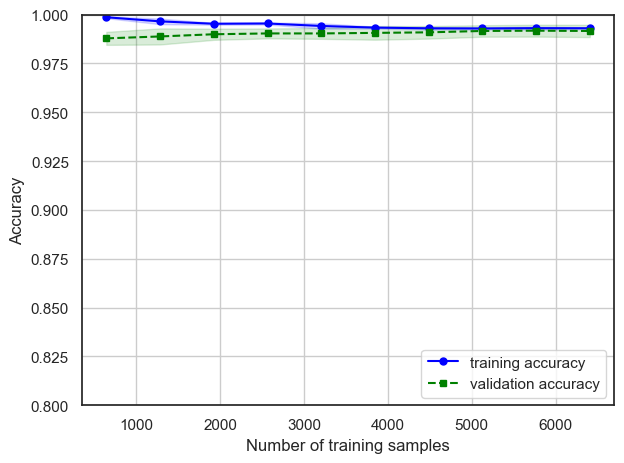

In [233]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('logreg', LogisticRegression(max_iter=1000000, solver='sag'))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

### F1

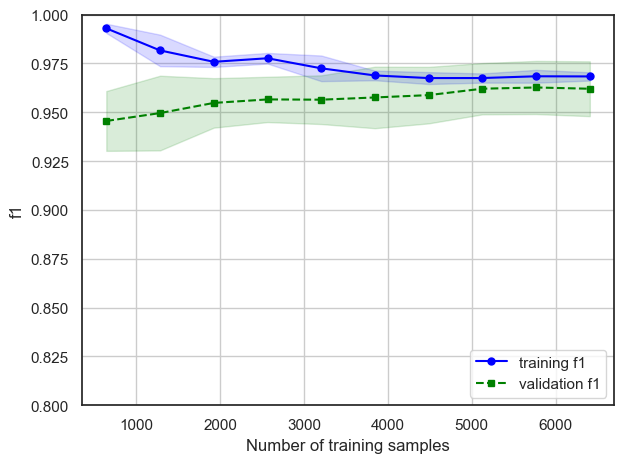

In [235]:
scorer = make_scorer(f1_score)

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('logreg', LogisticRegression(max_iter=1000000, solver='sag'))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               scoring = scorer,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training f1')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation f1')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('f1')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

## validation curve

### Accuracy

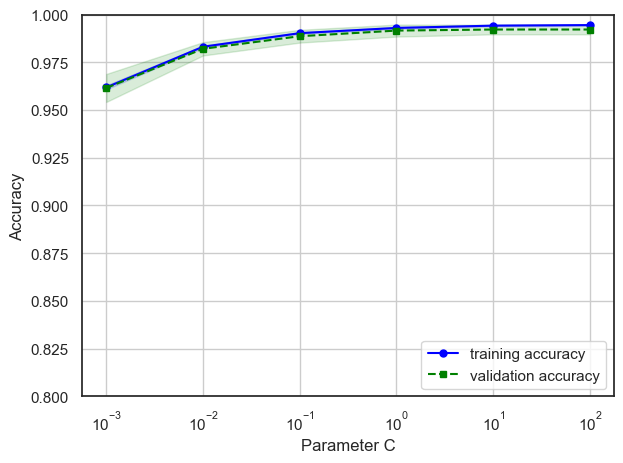

In [238]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logreg__C', 
                param_range=param_range,
                cv=10,
                n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()


### F1

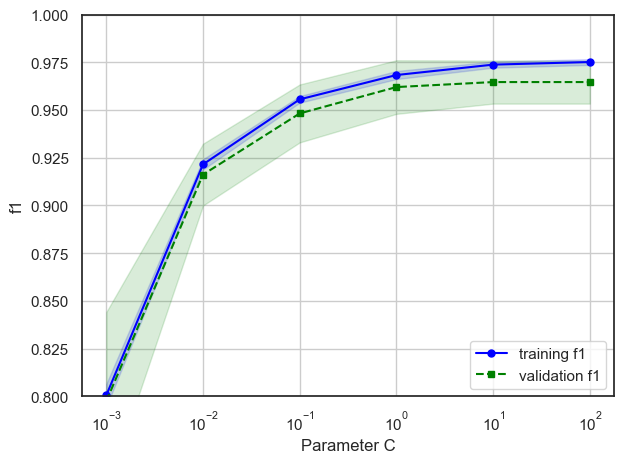

In [241]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                scoring = scorer,
                param_name='logreg__C', 
                param_range=param_range,
                cv=10,
                n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training f1')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation f1')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('f1')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()


# Something statistical

## Grubbs test

In [259]:
from scipy import stats

def grubbs_test(x, alpha):
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    print("Grubbs Calculated Value:",g_calculated)
    t_value = stats.t.ppf(1 - alpha / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    print("Grubbs Critical Value:",g_critical)
    if g_critical > g_calculated:
        print("From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers\n")
        return 1
    else:
        print("From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers\n")
    return 0

In [250]:
df[[1]].describe()

1
count    8900.000000
mean      456.203712
std      2936.432072
min         0.000000
25%         0.000000
50%         0.000000
75%         5.705786
max    104783.609200

In [258]:
grubbs_test(df[[0]].to_numpy(), 0.05)

Grubbs Calculated Value: [8.7226368]
Grubbs Critical Value: 4.537778218357279
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers



In [267]:
for i in df.columns[:-1]:
    print(f'{i} feature ----------------')
    grubbs_test(df[[i]].to_numpy(), 0.05)


0 feature ----------------
Grubbs Calculated Value: [8.7226368]
Grubbs Critical Value: 4.537778218357279
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers

1 feature ----------------
Grubbs Calculated Value: [35.5306251]
Grubbs Critical Value: 4.537778218357279
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers

2 feature ----------------
Grubbs Calculated Value: [50.28952296]
Grubbs Critical Value: 4.537778218357279
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers

3 feature ----------------
Grubbs Calculated Value: [44.65642612]
Grubbs Critical Value: 4.537778218357279
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outli

## Isolation forest

In [268]:
from sklearn.ensemble import IsolationForest

In [311]:
df_iso_forest = df.iloc[:,:-1]
iso = IsolationForest()
y_outliers = iso.fit_predict(df_iso_forest)
df.shape

(8900, 31)

In [315]:
df[df.Label == 1].shape

(998, 31)

In [316]:
df_iso_forest = df
for i in range(len(y_outliers)):
    if y_outliers[i] == -1:
        df_iso_forest.drop(i, inplace = True)
df_iso_forest.shape

(8304, 31)

In [317]:
df_iso_forest[df_iso_forest.Label == 1].shape

(672, 31)

### UMAP plot after anomaly cut

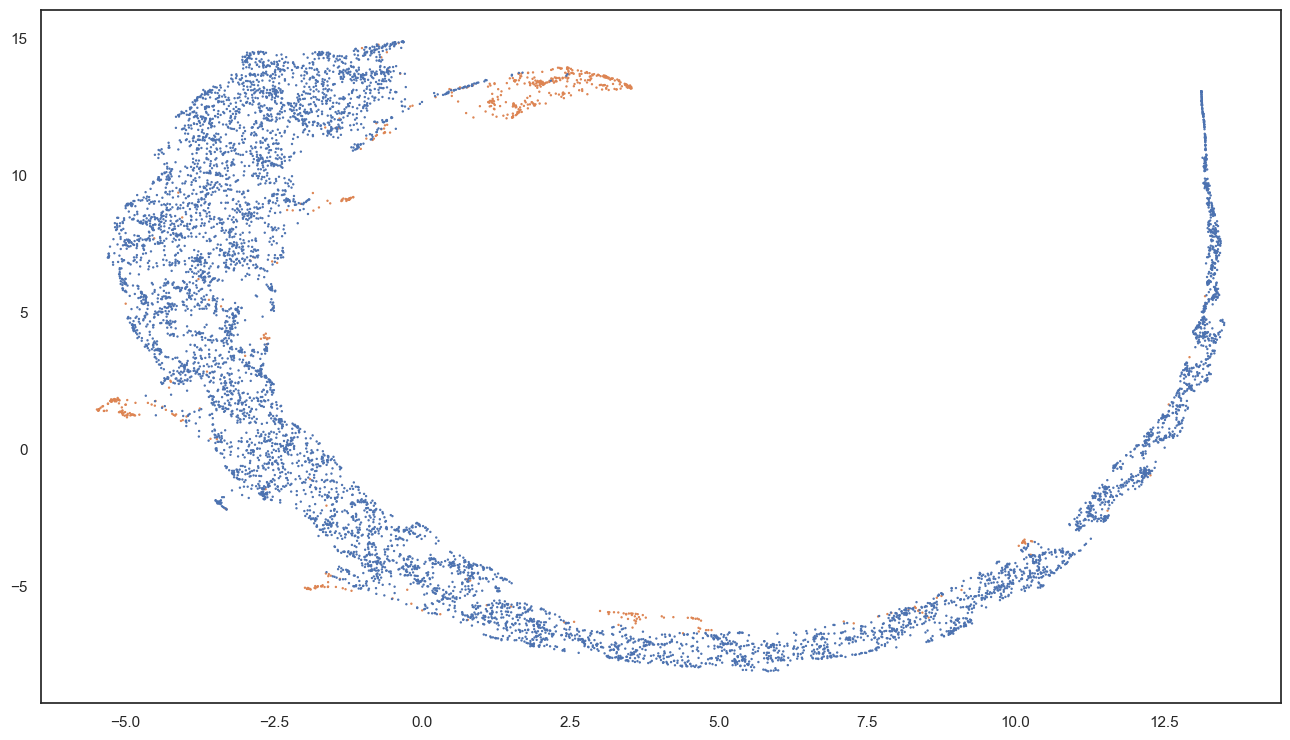

In [291]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(df_iso_forest.iloc[:, :-1])

fig = plt.subplots(figsize=(16, 9))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s = 0.5,
    # c = df_scaled_1_drop.iloc[:, -1]
    c=[sns.color_palette()[x] for x in df_scaled_1_drop.Label.map({0:0, 1:1})]
    )

### UMAP plot after anomaly cut SCALED

In [292]:
scaler = StandardScaler()
df_iso_forest_scaled = scaler.fit_transform(df_iso_forest.iloc[:, :-1])
df_iso_forest_scaled = pd.DataFrame(df_iso_forest_scaled)
df_iso_forest_scaled['Label'] = df['Label']

TypeError: list indices must be integers or slices, not float

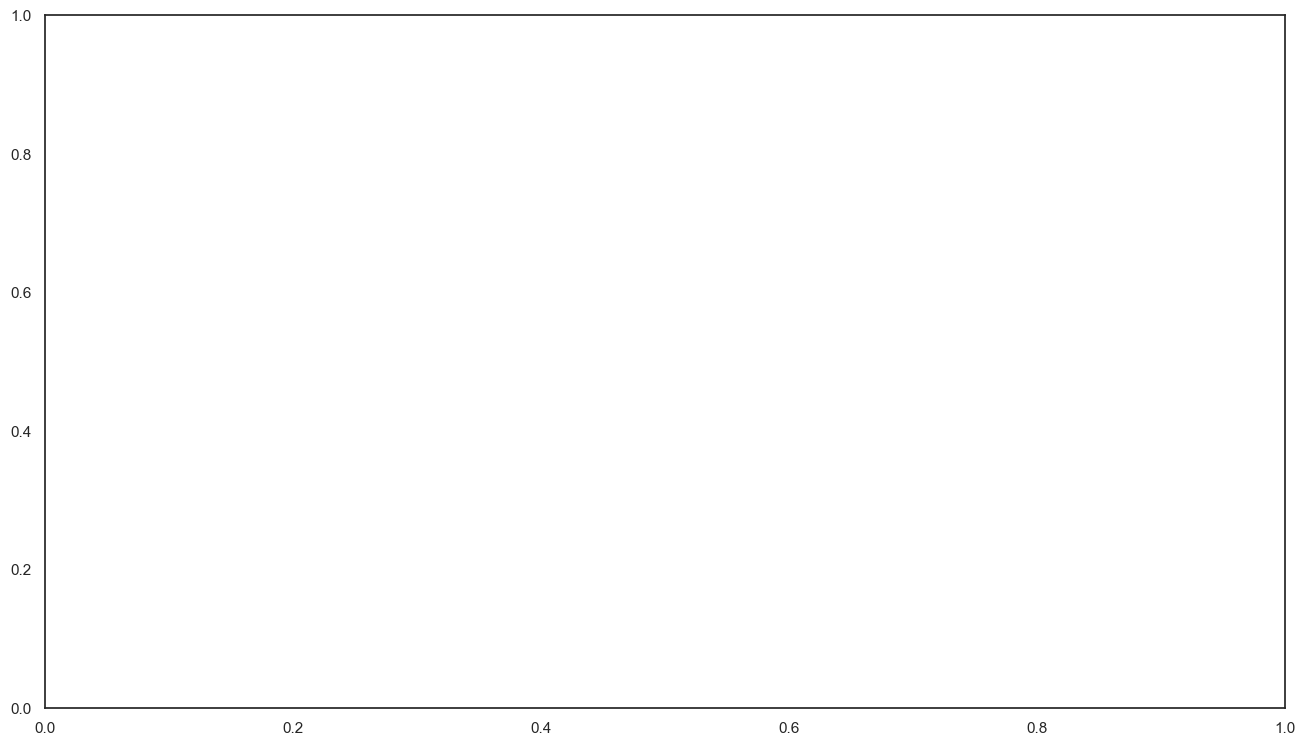

In [294]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(df_iso_forest_scaled.iloc[:, :-1])

fig = plt.subplots(figsize=(16, 9))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s = 0.5,
    # c = df_scaled_1_drop.iloc[:, -1]
    c=[sns.color_palette()[x] for x in df_iso_forest_scaled.Label.map({0:0, 1:1})]
    )

# Old

In [111]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.iloc[:, :-1])
df_scaled = pd.DataFrame(df_scaled)
df_scaled['Label'] = df['Label']

In [123]:
var = []
_CONF_LEVEL = 0.001
for i in prot.columns[:-2]:
    res = mannwhitneyu(prot[i], elec[i])
    var.append([res.pvalue, 'H0' if res.pvalue > _CONF_LEVEL else 'H1'])
stat_test_res = pd.DataFrame(var, columns=('Mannwhitneyu p-value', 'Mannwhitneyu hypothesis'))

display(stat_test_res)


Mannwhitneyu p-value Mannwhitneyu hypothesis
0           0.000000e+00                      H1
1           0.000000e+00                      H1
2          2.740501e-121                      H1
3          4.688180e-152                      H1
4           5.798648e-08                      H1
5          1.180080e-152                      H1
6          8.123678e-282                      H1
7           0.000000e+00                      H1
8          6.050780e-152                      H1
9           2.222816e-48                      H1
10          2.109012e-72                      H1
11         2.470767e-199                      H1
12          0.000000e+00                      H1
13         4.135585e-208                      H1
14         3.678837e-206                      H1
15         3.488357e-216                      H1
16         7.634233e-227                      H1
17          2.298605e-24                      H1
18          1.201275e-59                      H1
19         3.377754e-127                      H1
20         1.094782e-214                      H1
21          0.000000e+00                      H1
22          0.000000e+00                      H1
23         1.652746e-118                      H1
24         9.179779e-207                      H1
25          0.000000e+00                      H1
26          2.441677e-01                      H0
27         1.212301e-300                      H1
28          8.805270e-01                      H0
29          4.871109e-03                      H0

In [124]:
df_1_drop = df.drop(columns=[26,28,29])

In [125]:
df_scaled_1_drop = df_scaled.drop(columns=[26,28,29])

<Axes: >

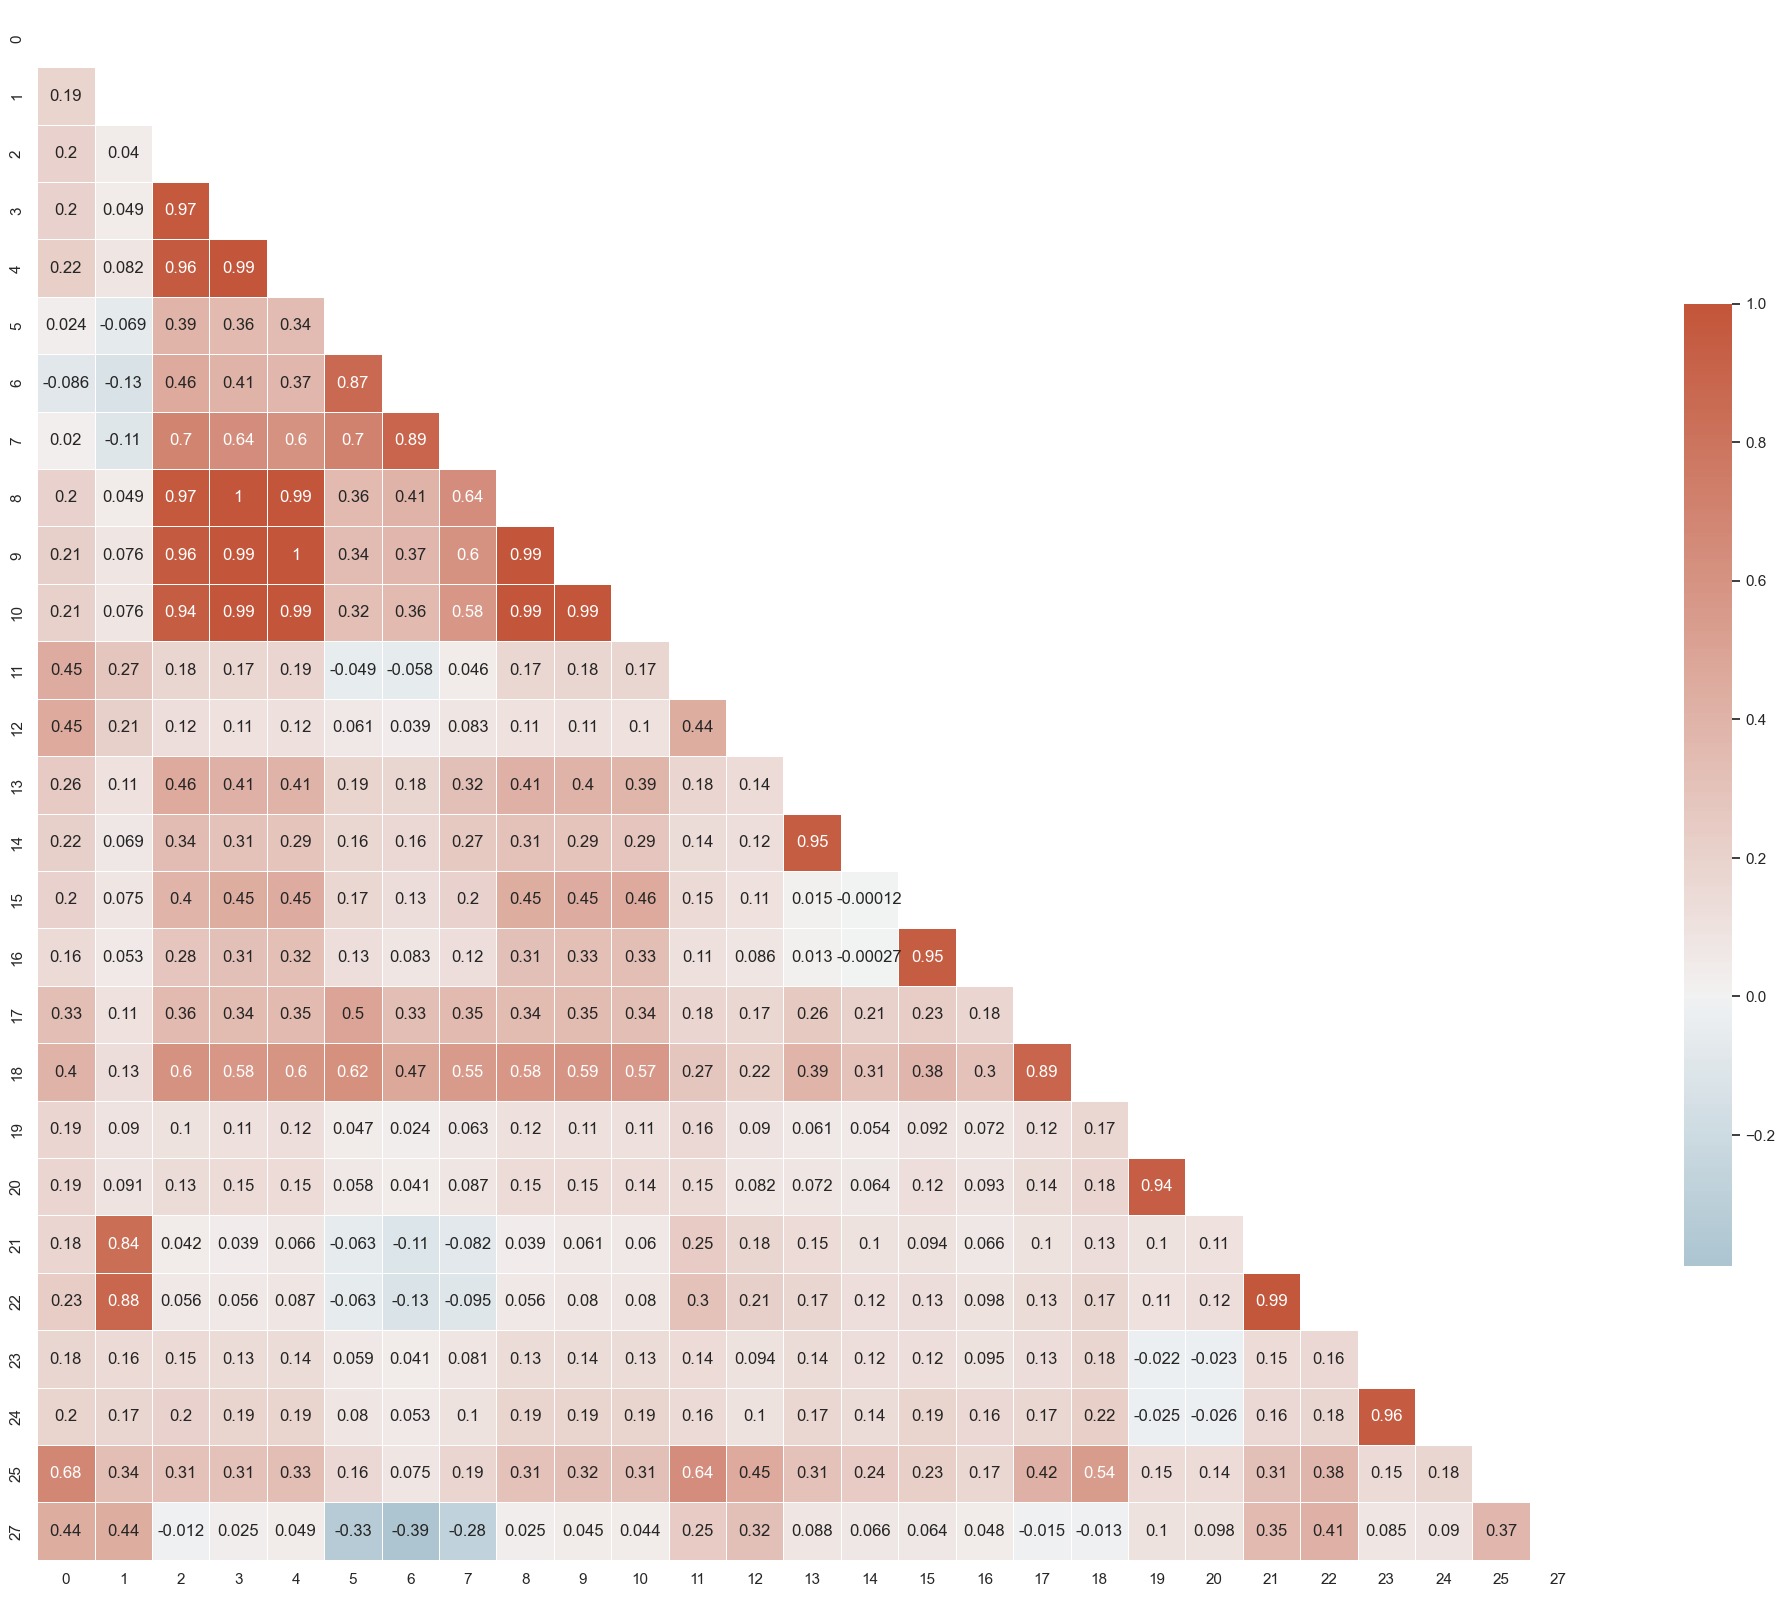

In [126]:
corr = df_1_drop.iloc[:, :-1].corr()
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [127]:
# corr = df_1_drop.iloc[:, :-1].corr()
# sns.set_theme(style="white")

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(25, 25))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [128]:
# sns.pairplot(df_scaled_1_drop.iloc[:, :-4], hue='Label')

## UMAP PIC

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.iloc[:, :-1])
df_scaled = pd.DataFrame(df_scaled)
df_scaled['Label'] = df['Label']

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [159]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(pd.DataFrame(X_train_std).iloc[:, :-1])
emb_df = pd.DataFrame(embedding)
emb_df['Label'] = y_train
emb_prot = emb_df[emb_df.Label == 0]
emb_elec = emb_df[emb_df.Label == 1]
emb_prot.drop(columns='Label', inplace=True)
emb_elec.drop(columns='Label', inplace=True)
emb_prot = emb_prot.to_numpy() 
emb_elec = emb_elec.to_numpy()


/var/folders/y5/dqknd6mj4l965pqd1q8tspvm0000gn/T/ipykernel_50034/1590437354.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb_prot.drop(columns='Label', inplace=True)
/var/folders/y5/dqknd6mj4l965pqd1q8tspvm0000gn/T/ipykernel_50034/1590437354.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb_elec.drop(columns='Label', inplace=True)


/var/folders/y5/dqknd6mj4l965pqd1q8tspvm0000gn/T/ipykernel_50034/4035952809.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend.legendHandles:


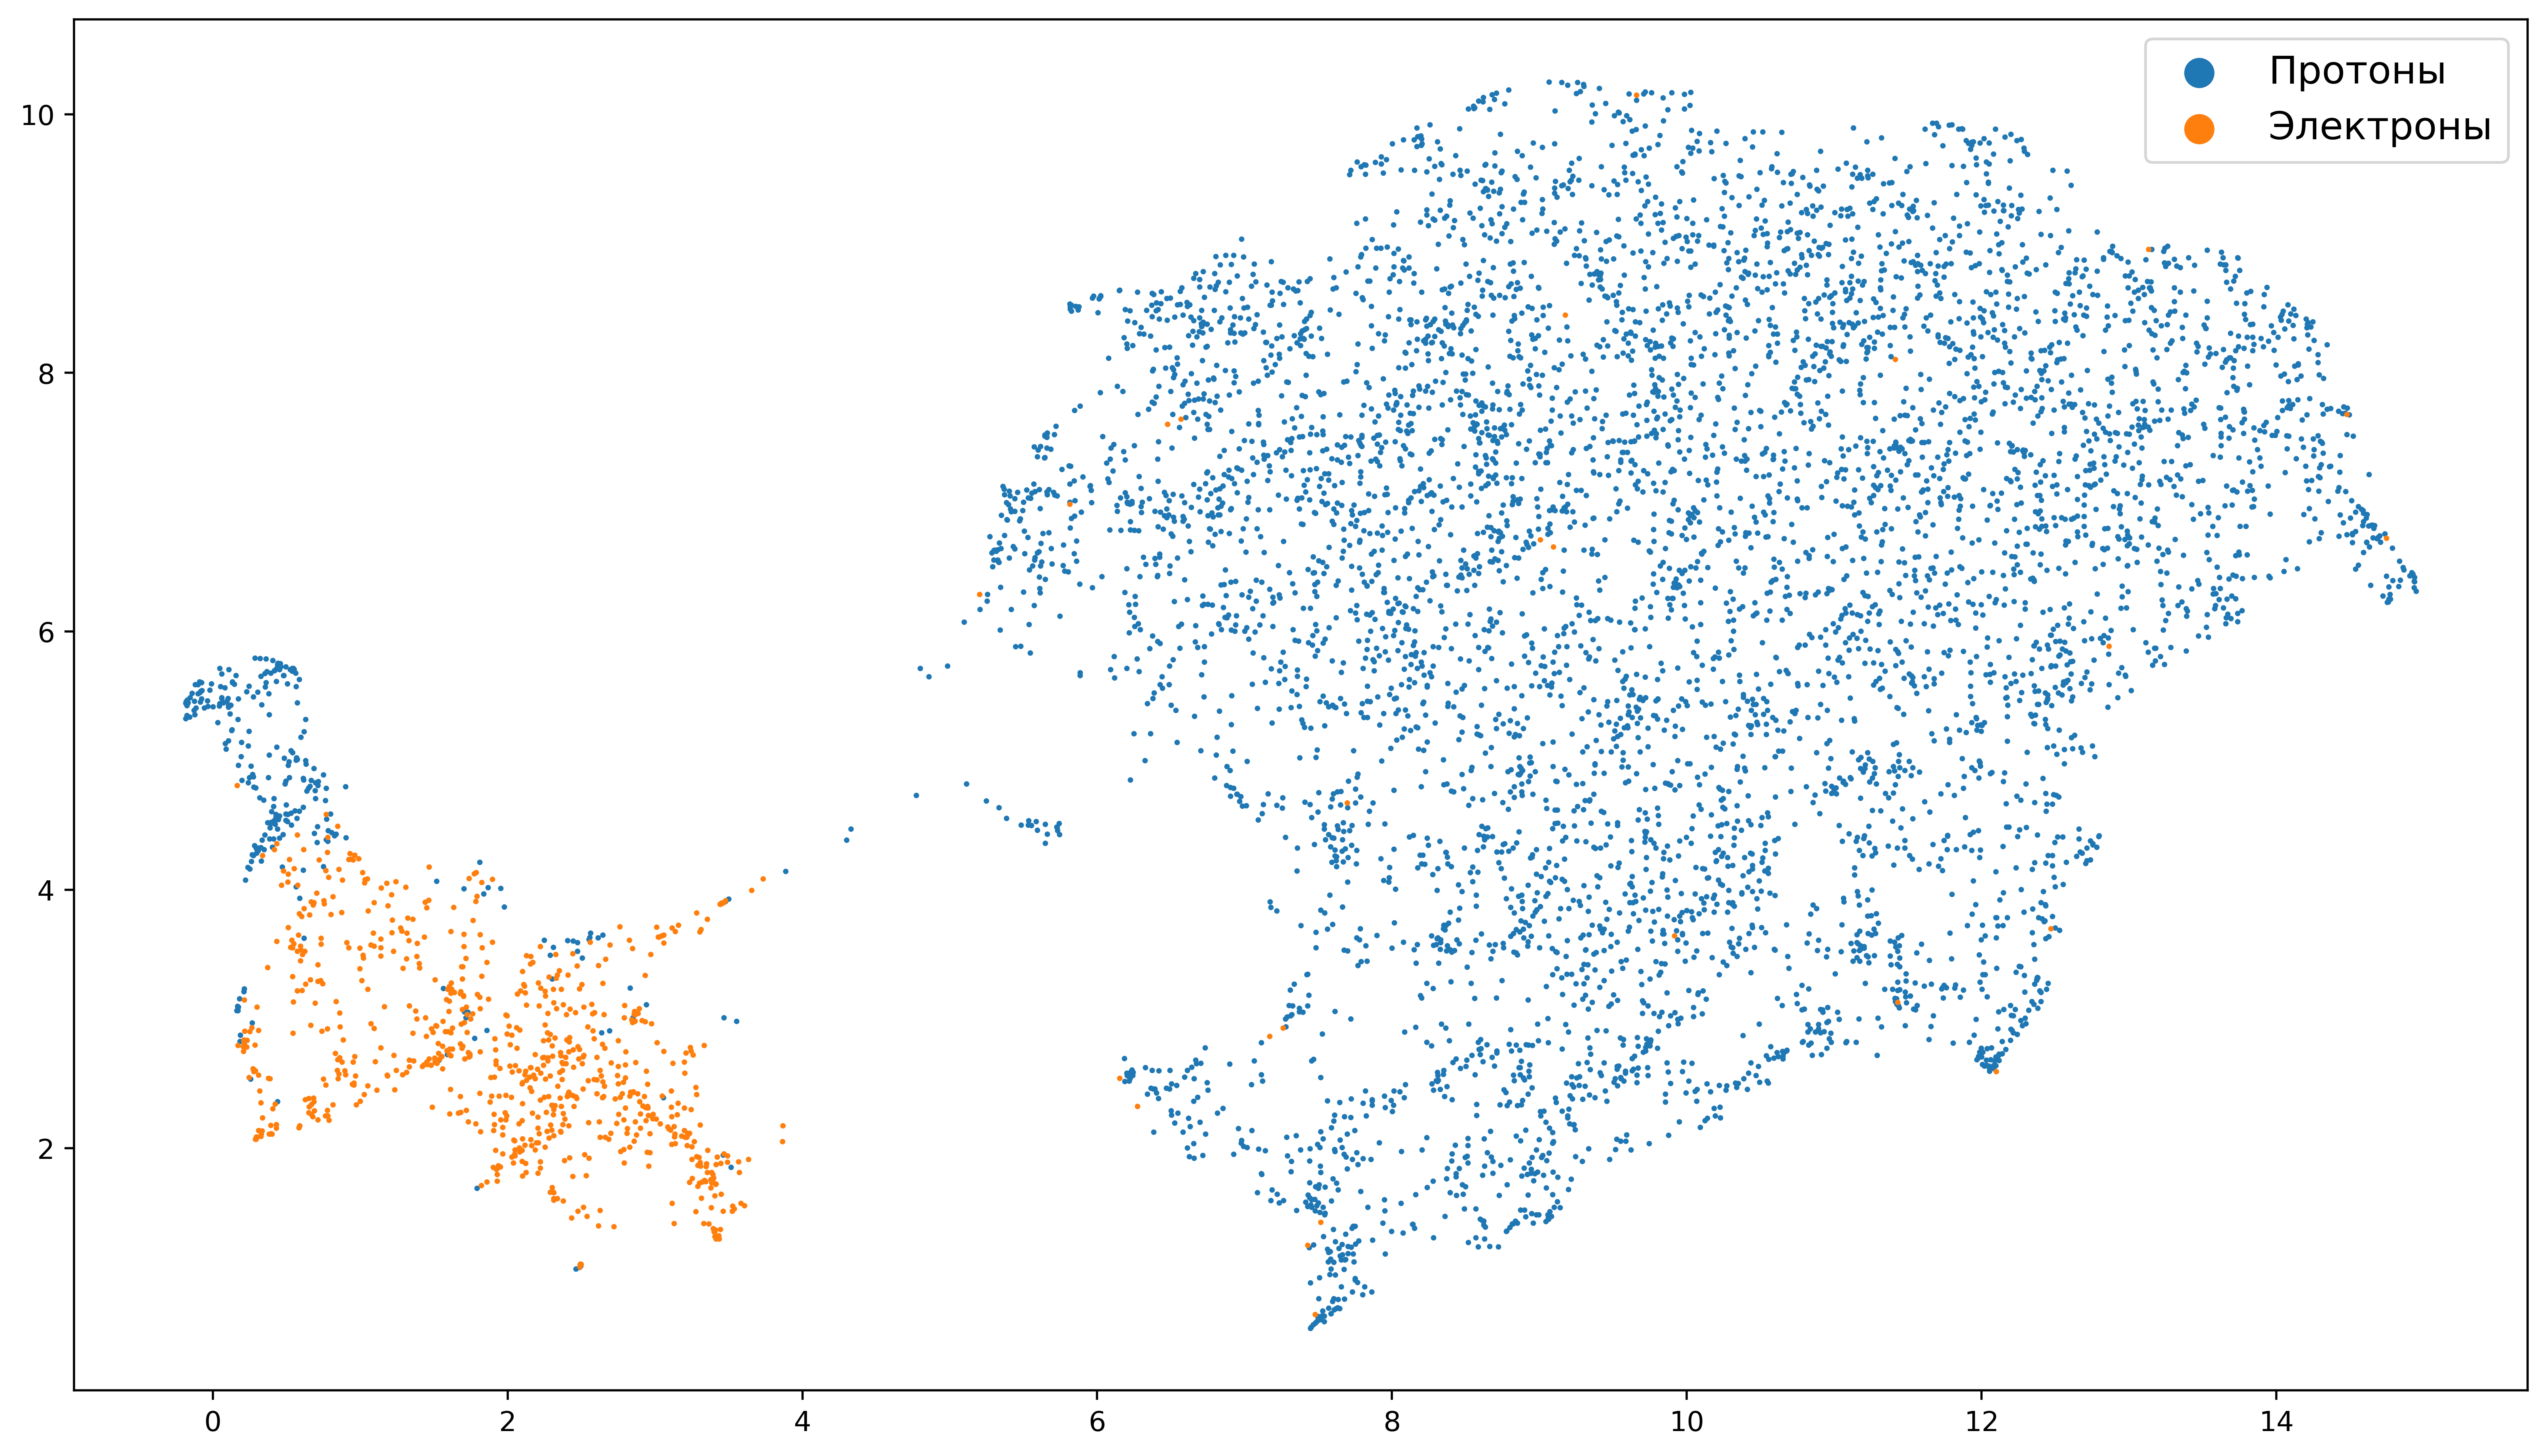

In [161]:

fig = plt.figure(figsize=(16, 9), dpi=500)
scatter_proton = plt.scatter(
    emb_prot[:, 0],
    emb_prot[:, 1],
    s = 1,
    # c = df_scaled_1_drop.iloc[:, -1]
    color=sns.color_palette()[0],
    label='Протоны'
    # c=sns.color_palette()[0]
    )
scatter_elec = plt.scatter(
    emb_elec[:, 0],
    emb_elec[:, 1],
    s = 1,
    # c = df_scaled_1_drop.iloc[:, -1]
    color=sns.color_palette()[1],
    label='Электроны'
    # c=sns.color_palette()[0]
    )
legend = plt.legend(fontsize=14)
for legobj in legend.legendHandles:
    legobj.set_sizes([100])
# plt.legend(handles=u.legend_elements(), labels=['prot', 'elec'])
plt.show()
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the Penguin dataset', fontsize=24);

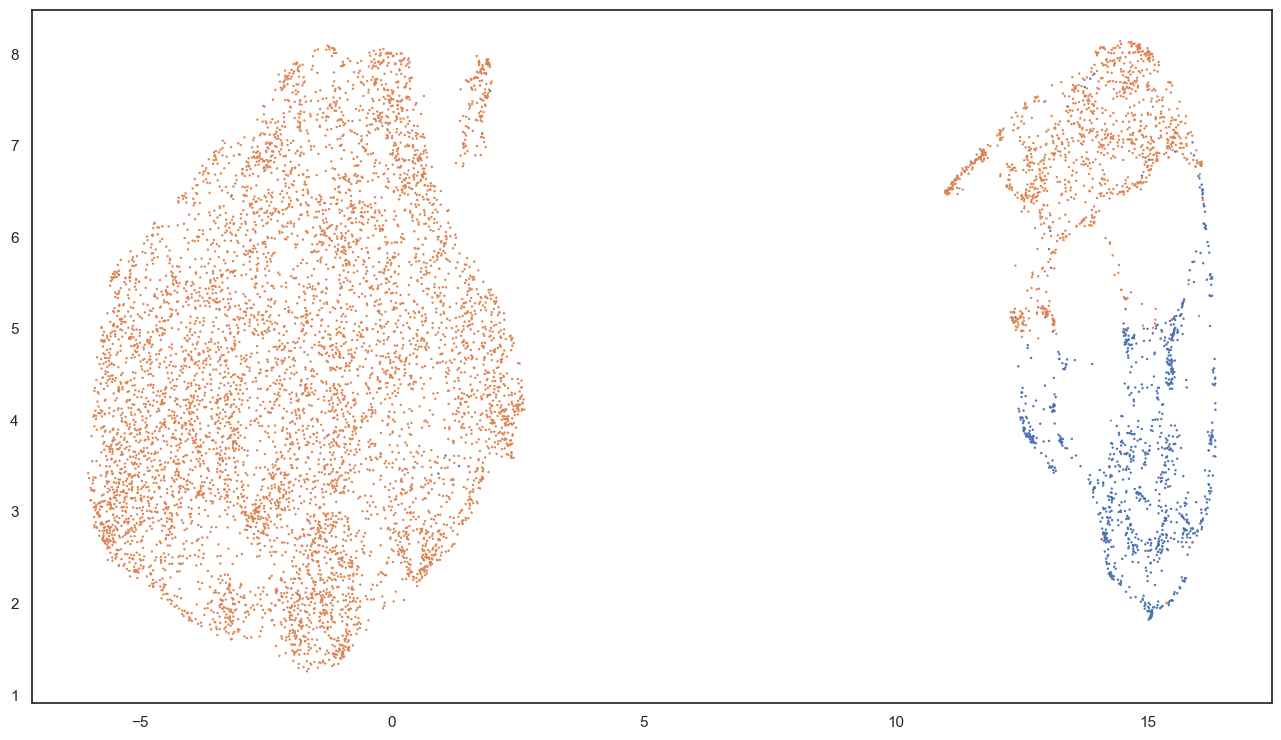

In [130]:
scaler = QuantileTransformer()
var = scaler.fit_transform(df_1_drop.iloc[:, :-1])
var = pd.DataFrame(var)
var['Label'] = df['Label']

fig = plt.subplots(figsize=(16, 9))
reducer = umap.UMAP()
embedding = reducer.fit_transform(var.iloc[:, :-1])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s = 0.5,
    # c = df_scaled_1_drop.iloc[:, -1]
    c=[sns.color_palette()[x] for x in var.Label.map({0:0, 1:1})]
    )


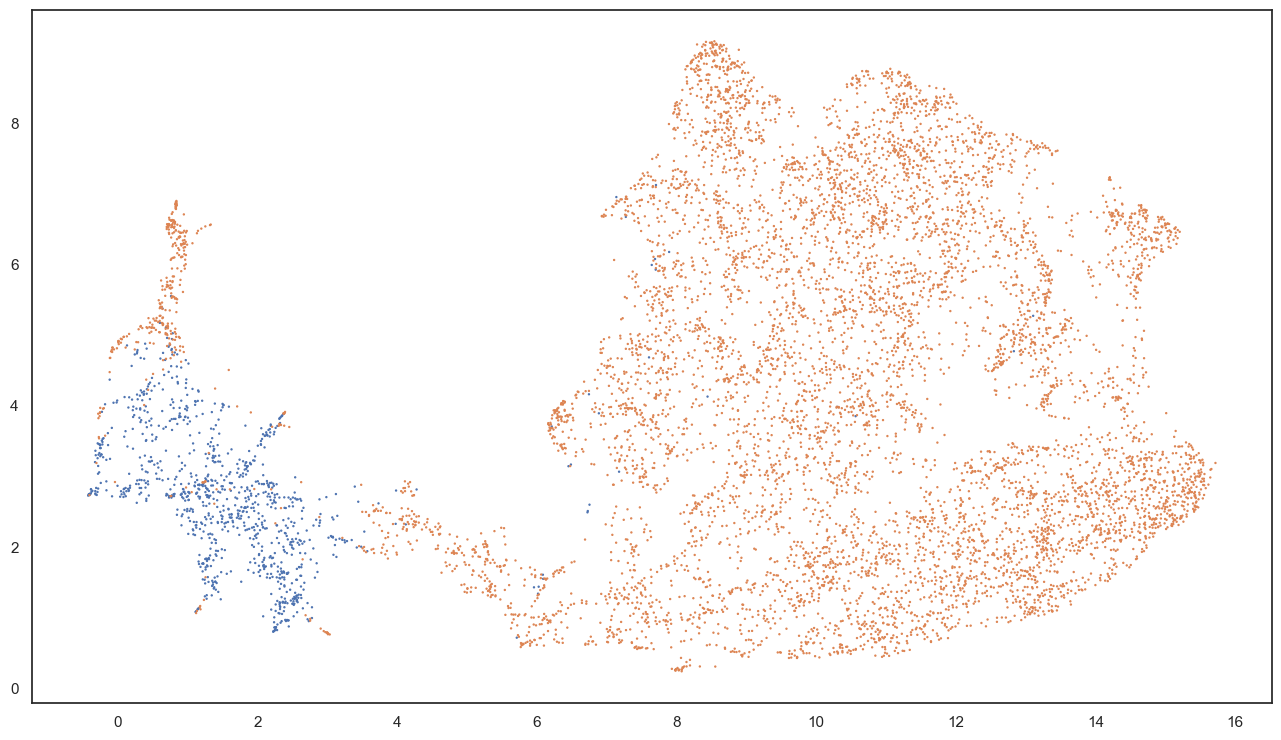

In [131]:
scaler = StandardScaler()
var = scaler.fit_transform(df_1_drop.iloc[:, :-1])
var = pd.DataFrame(var)
var['Label'] = df['Label']

reducer = umap.UMAP()
embedding = reducer.fit_transform(var.iloc[:, :-1])
fig = plt.subplots(figsize=(16, 9))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s = 0.5,
    # c = df_scaled_1_drop.iloc[:, -1]
    c=[sns.color_palette()[x] for x in var.Label.map({0:0, 1:1})]
    )


In [132]:
reducer = umap.UMAP(n_components=10)
embedding = reducer.fit_transform(df_scaled_1_drop.iloc[:, :-1])

<Axes: >

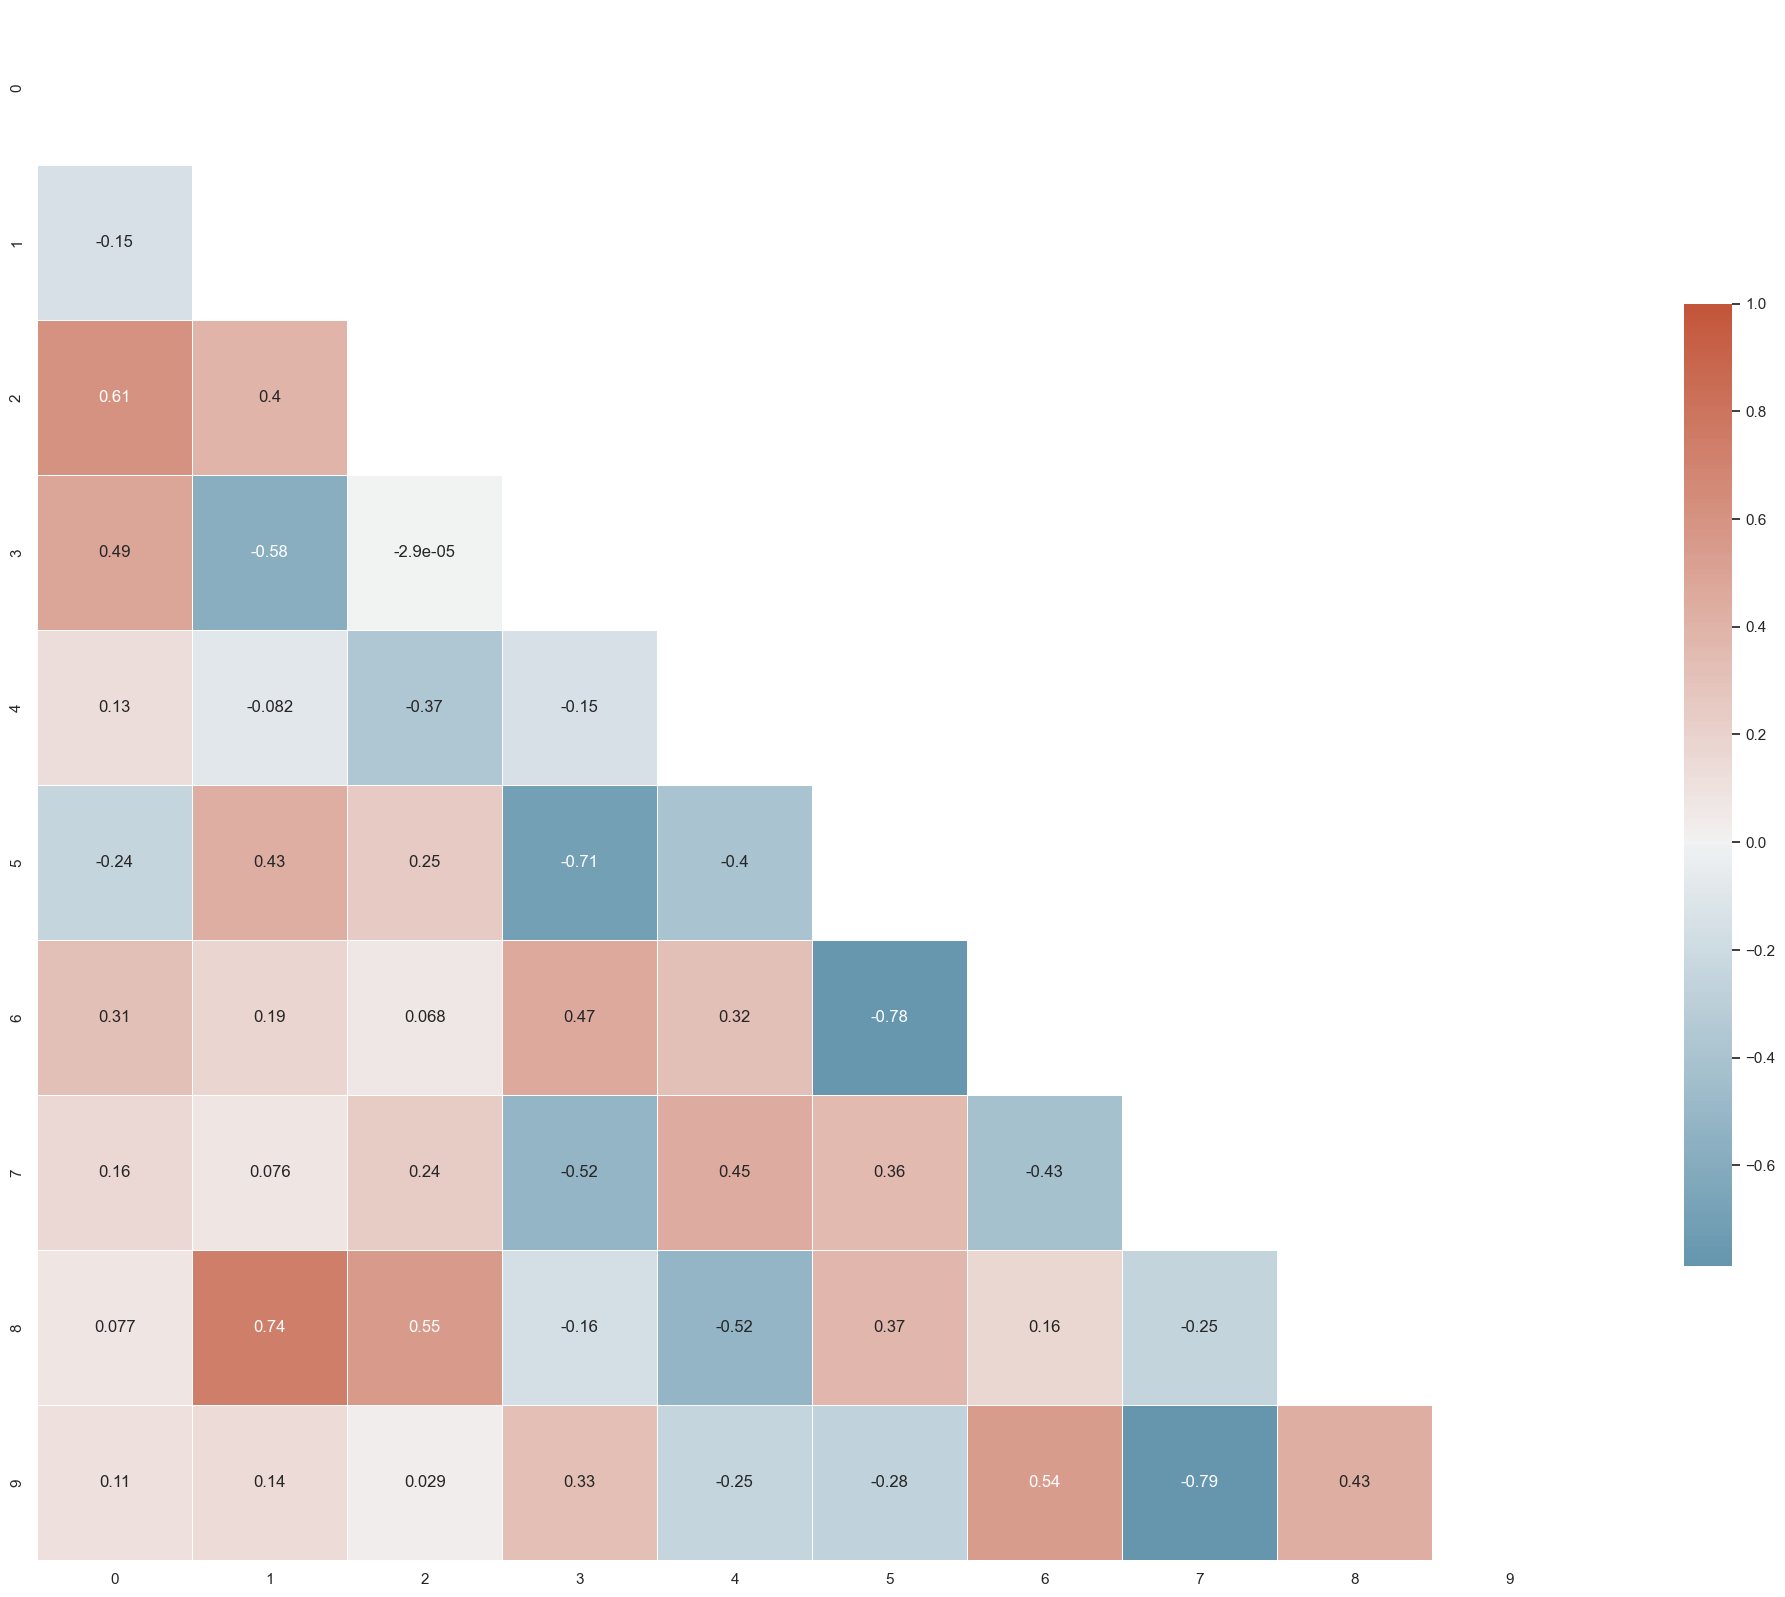

In [133]:
corr = pd.DataFrame(embedding).corr()
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [134]:
# %reset_selective var

## Density plots

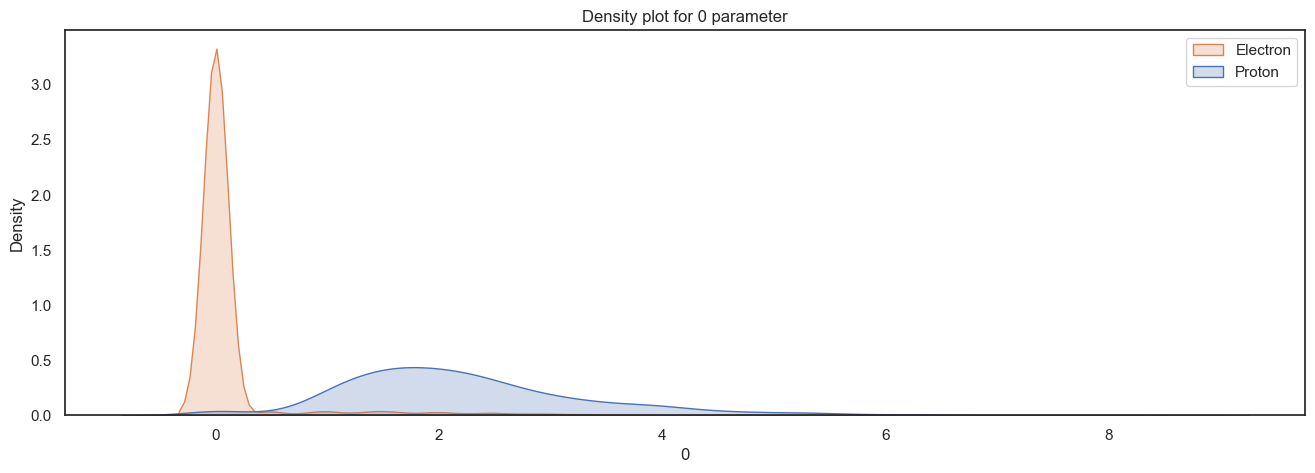

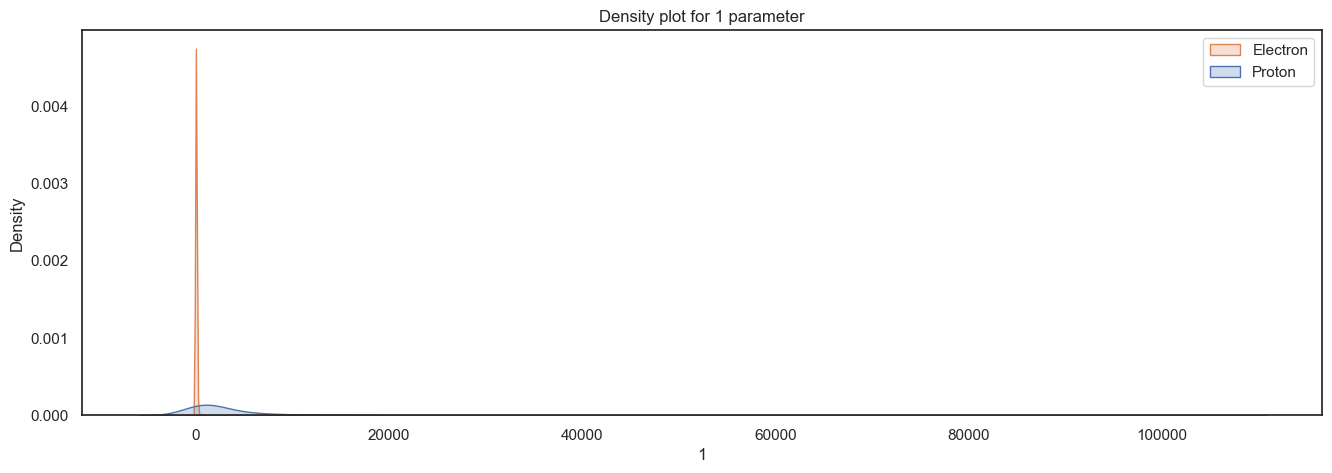

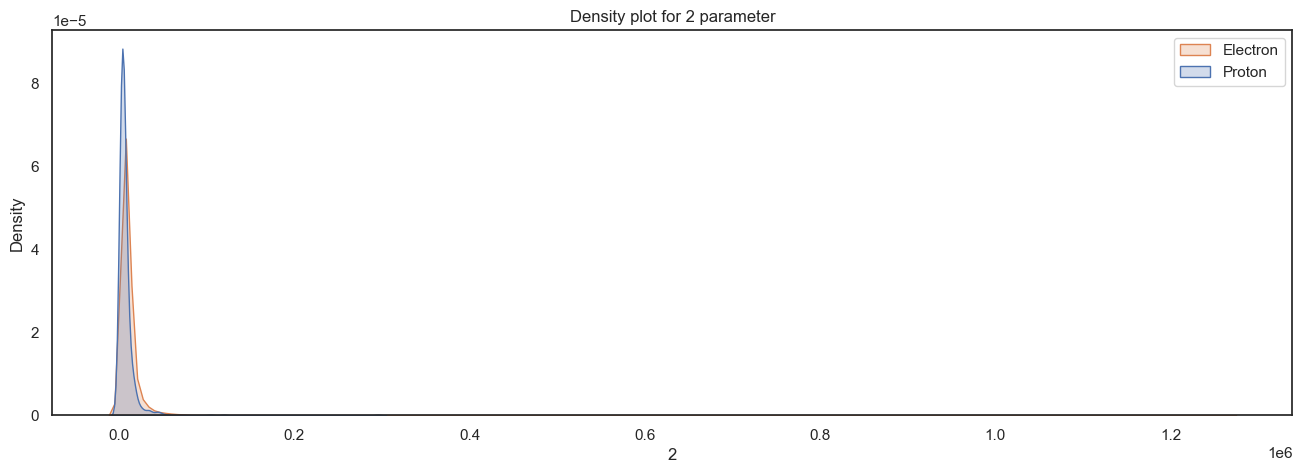

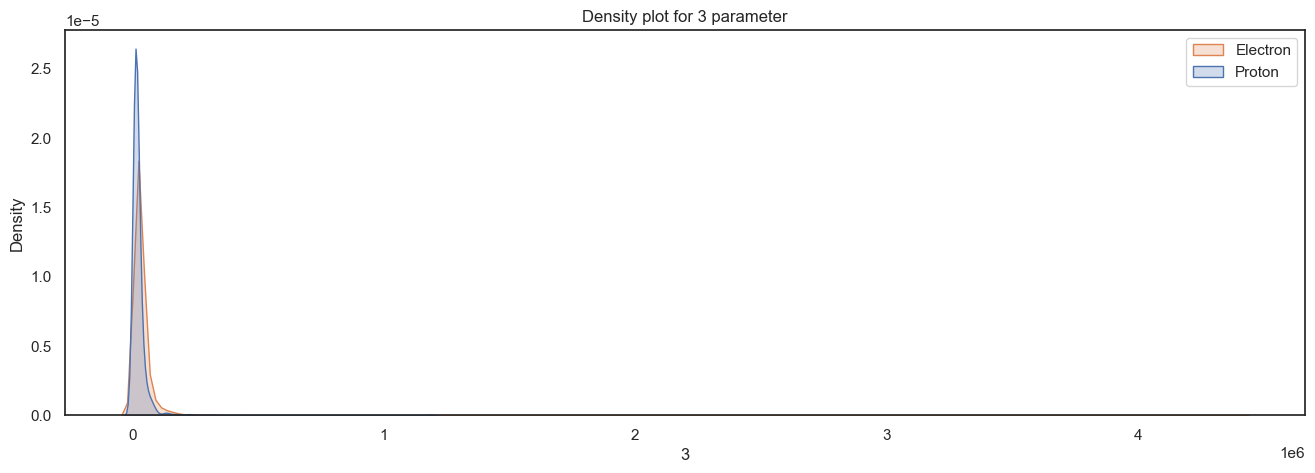

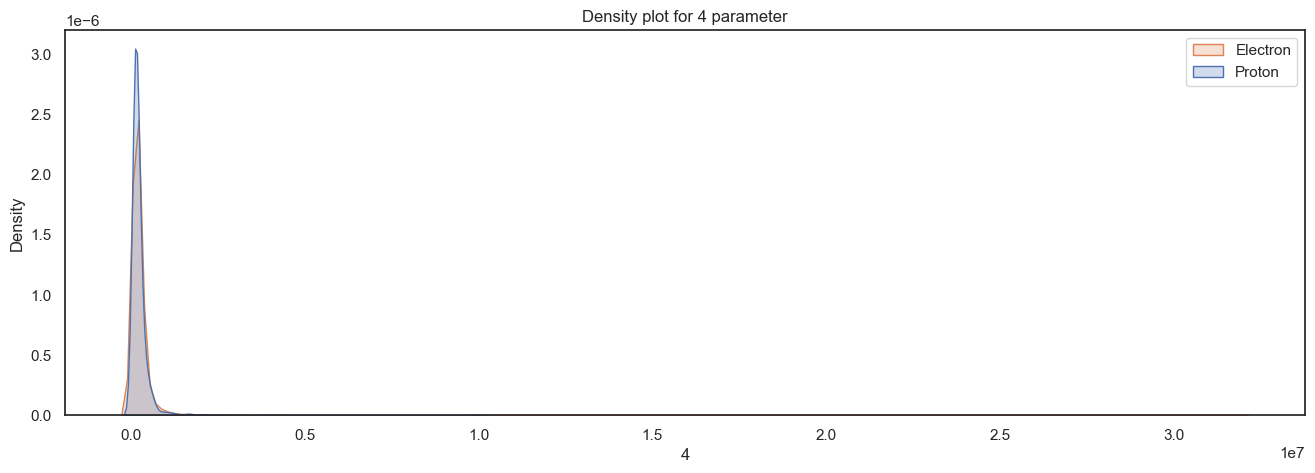

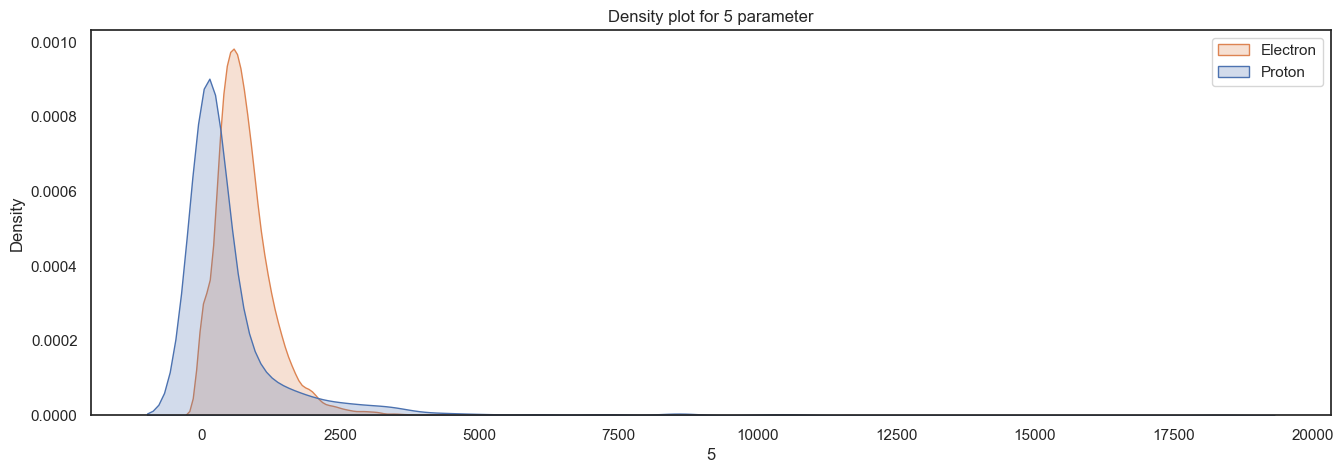

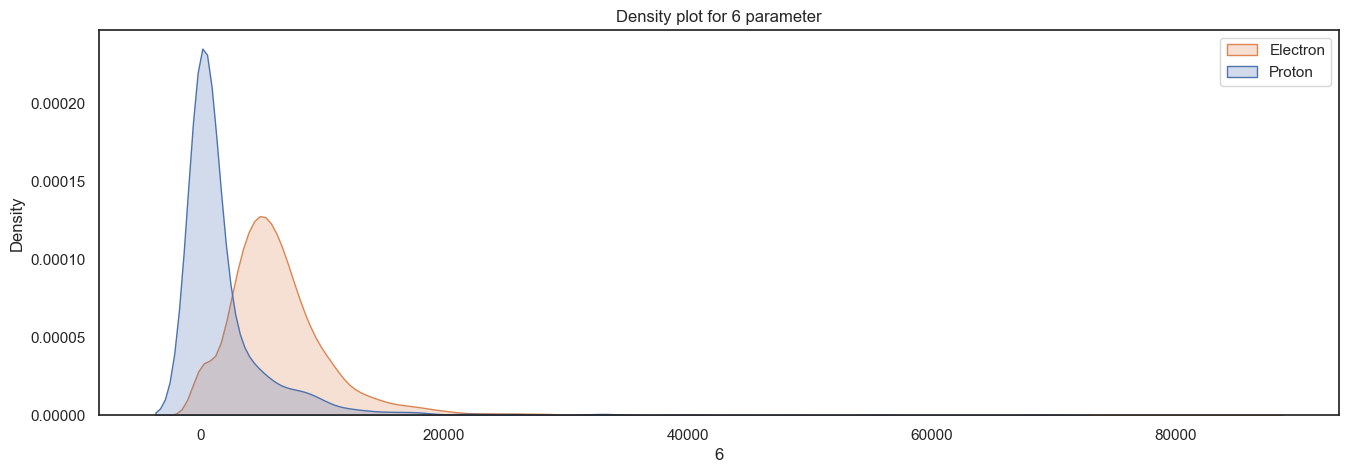

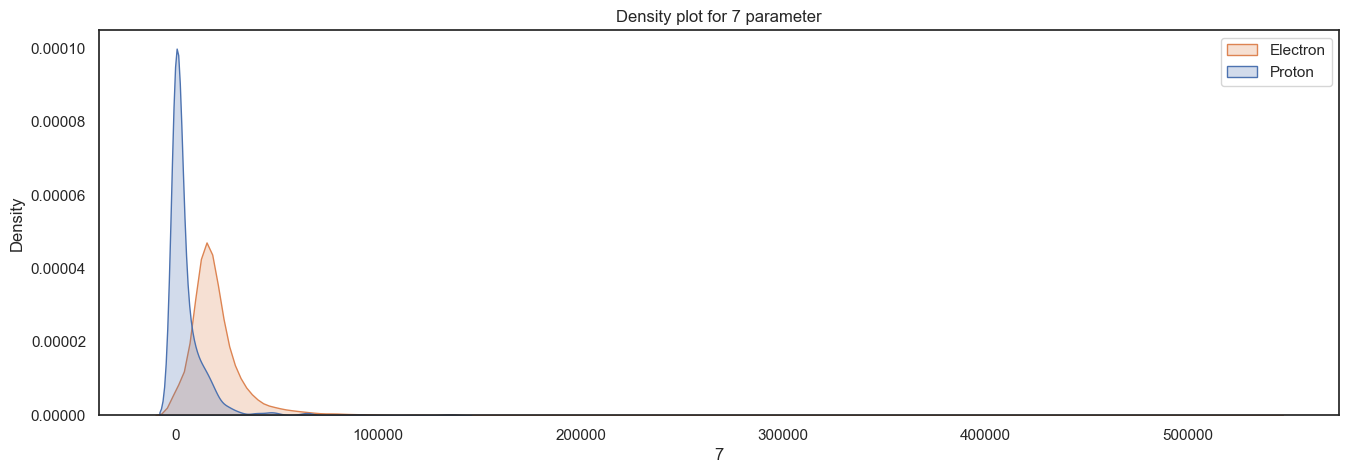

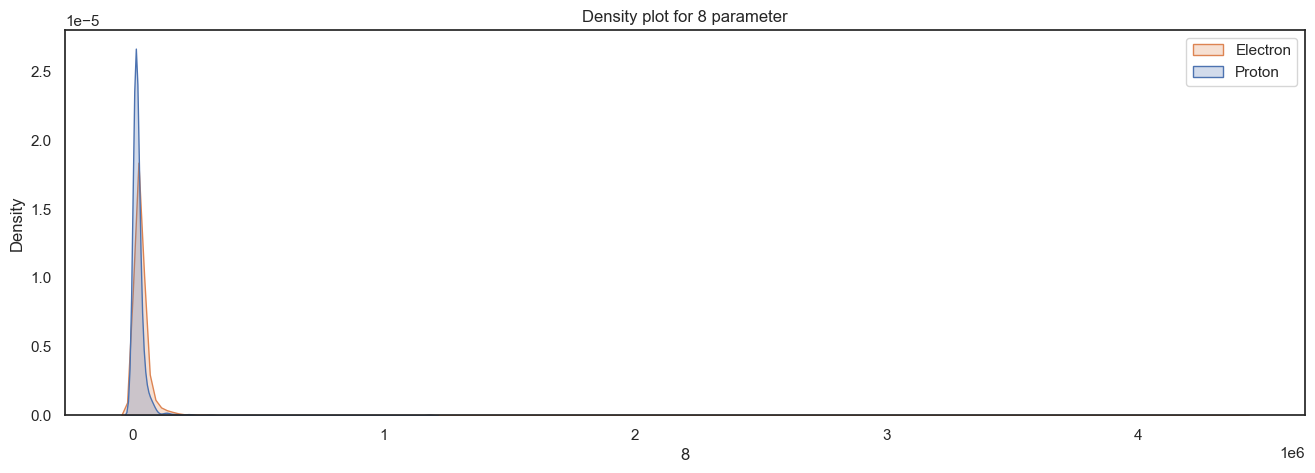

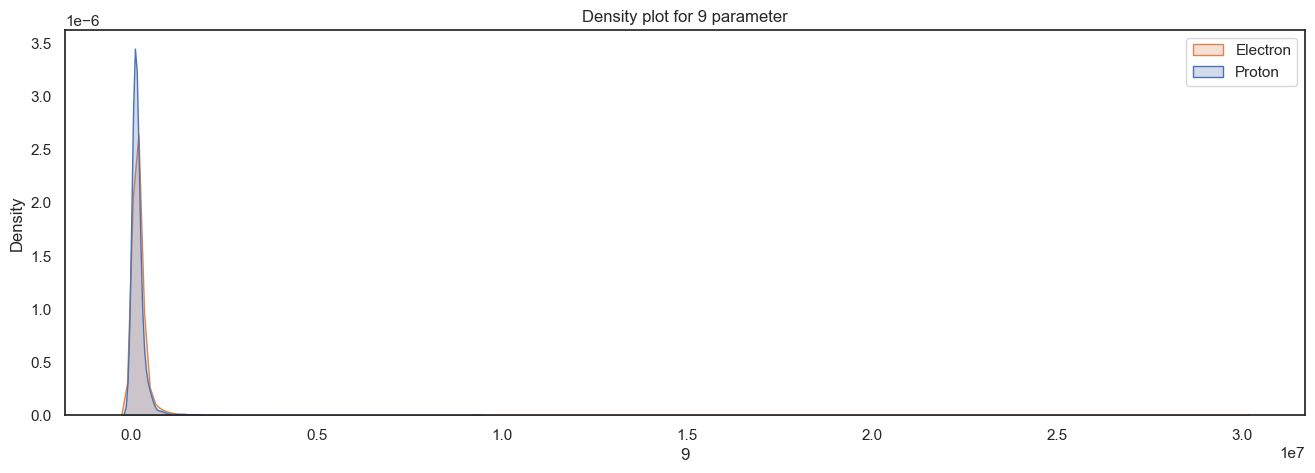

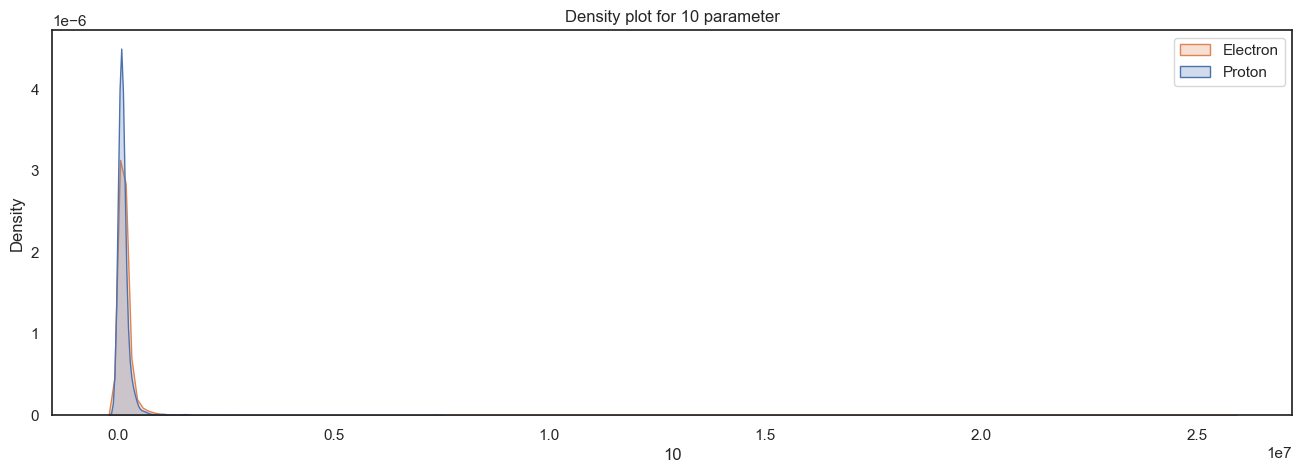

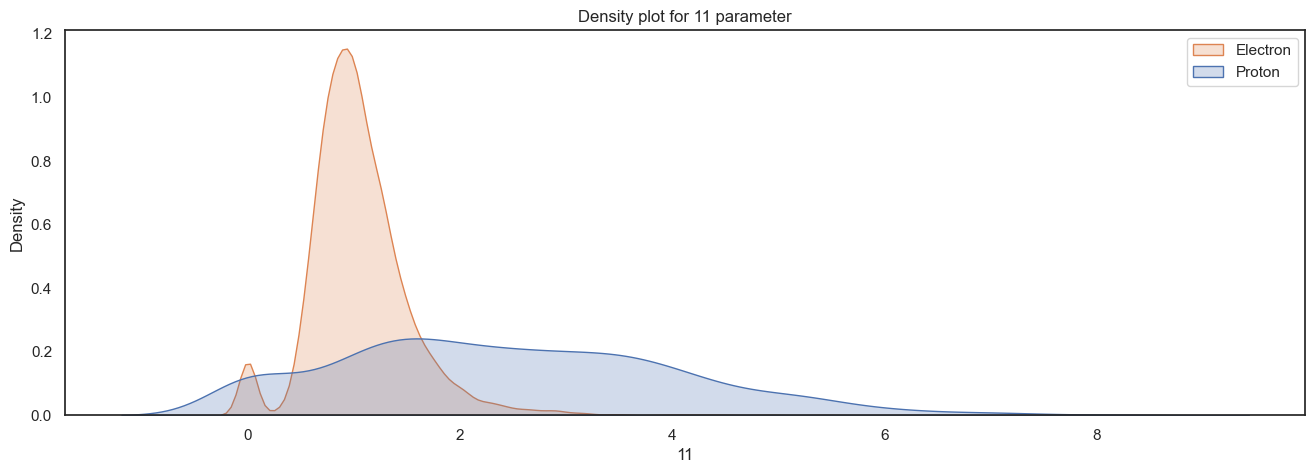

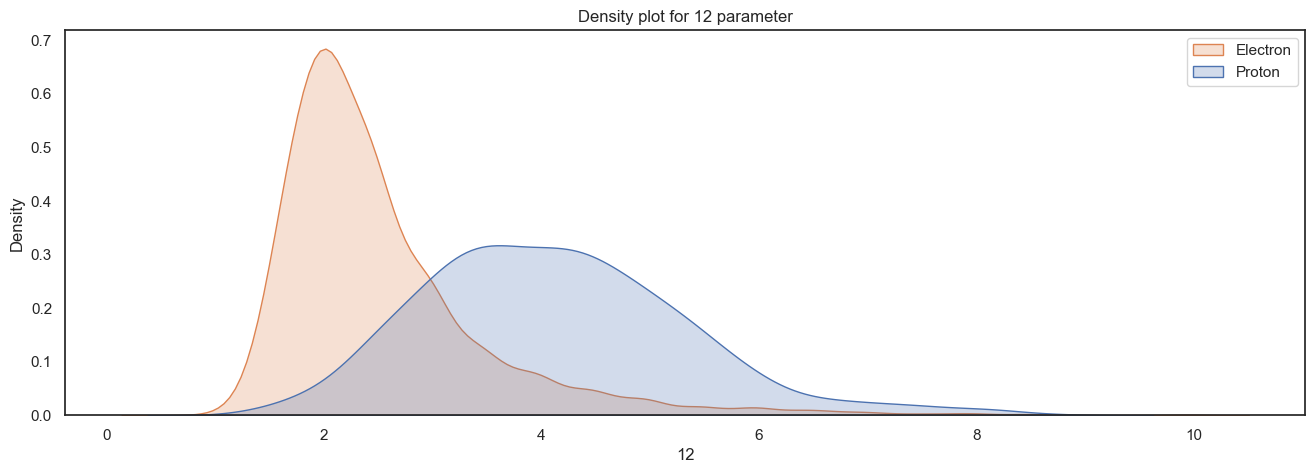

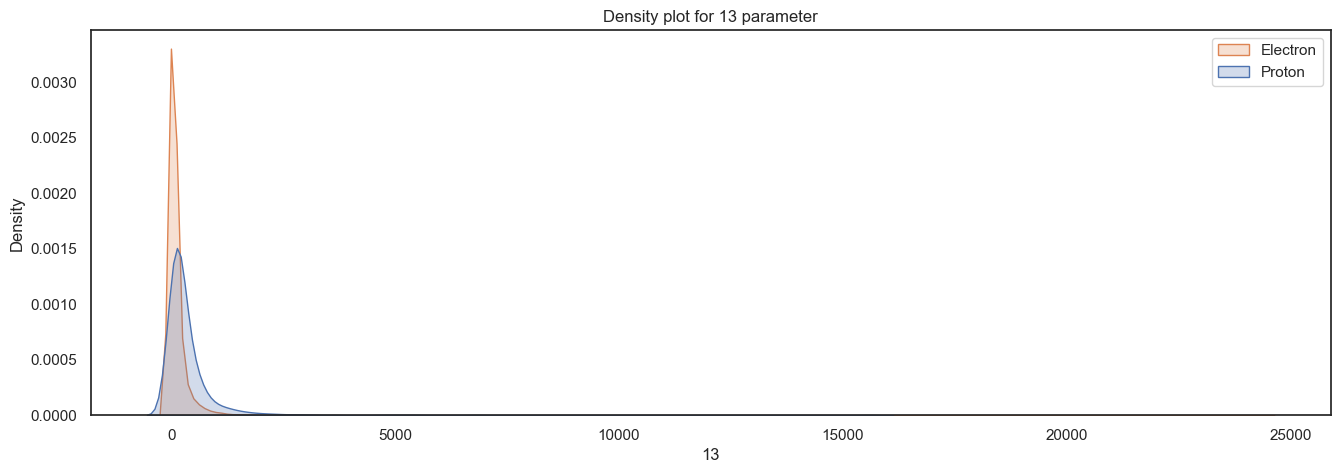

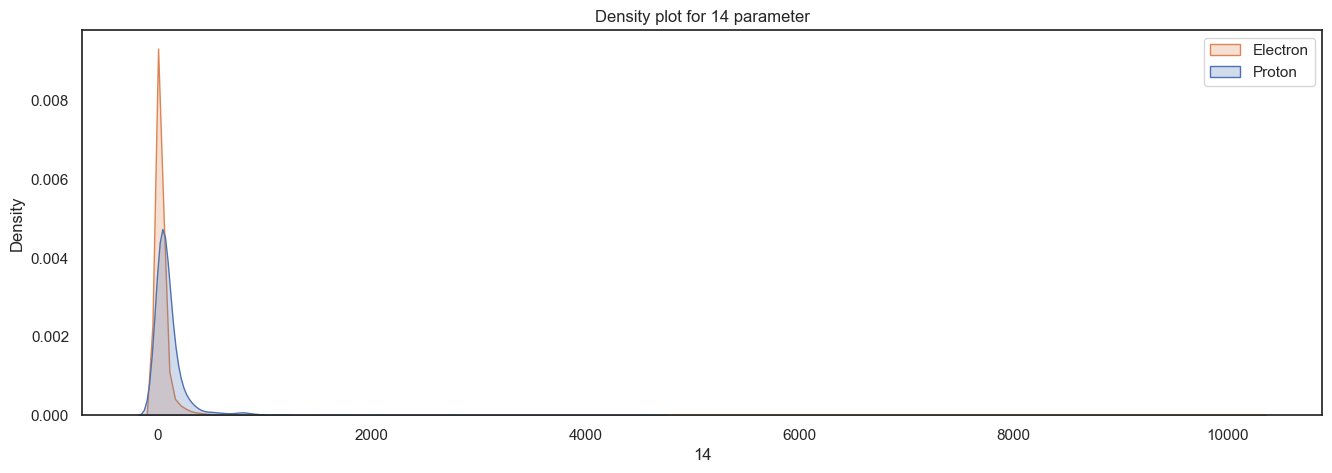

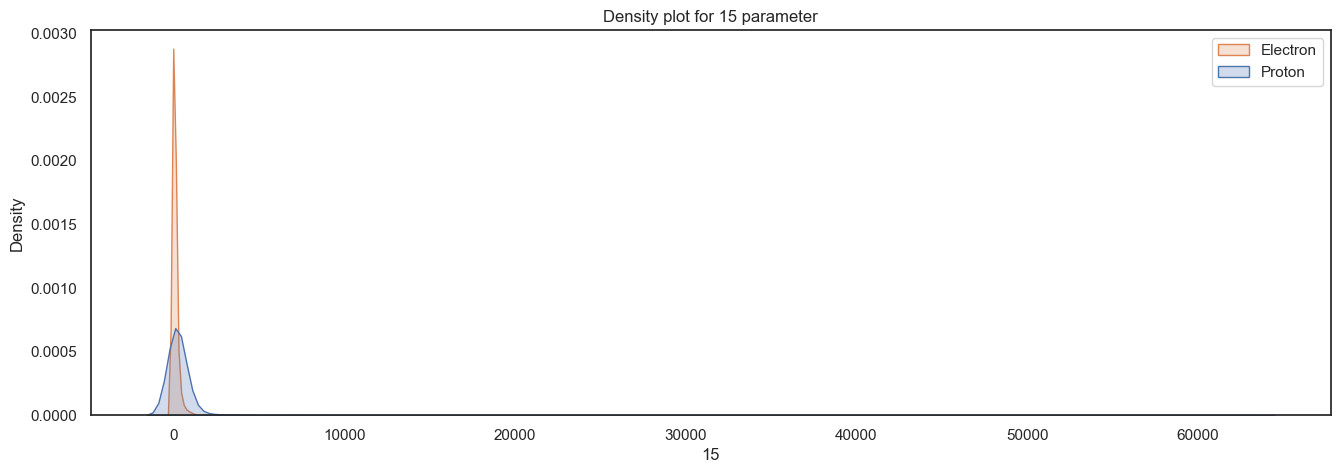

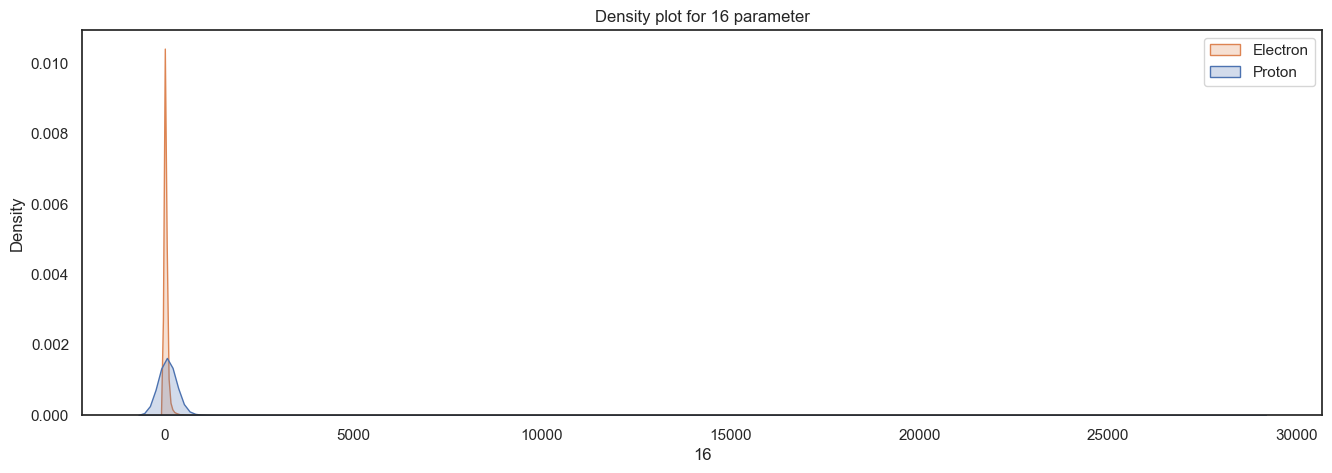

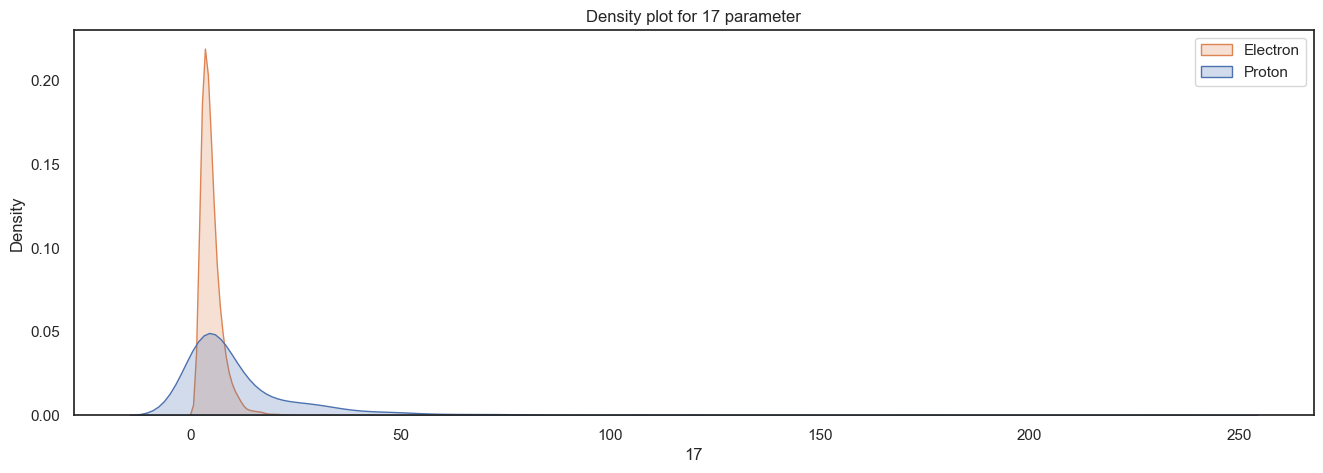

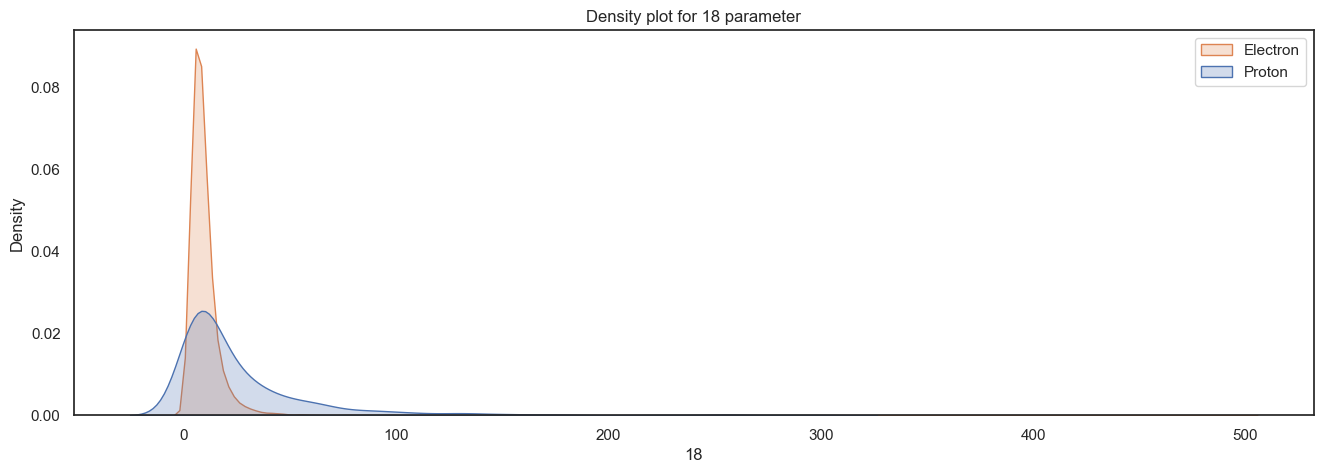

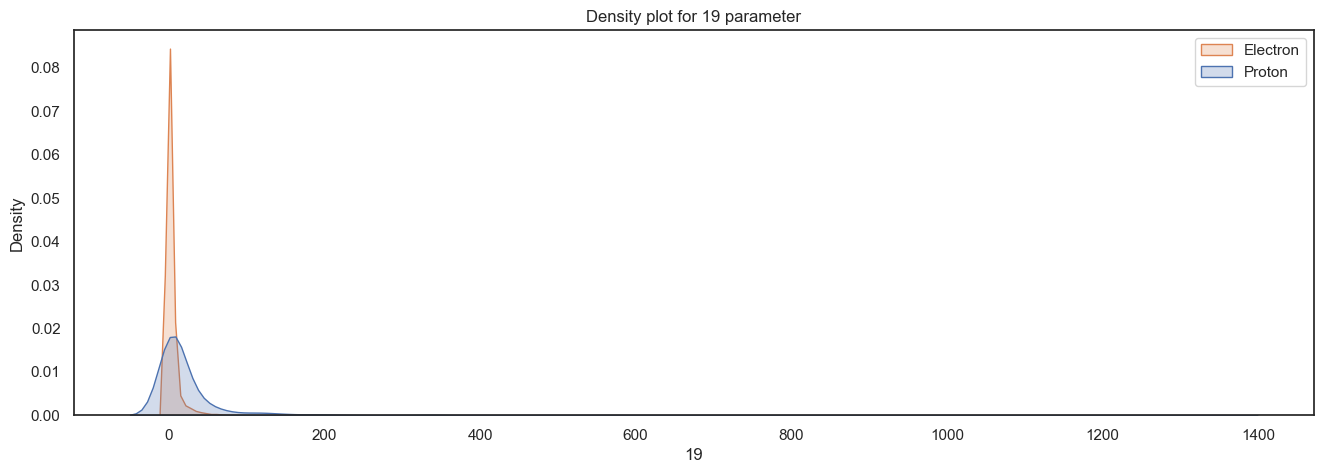

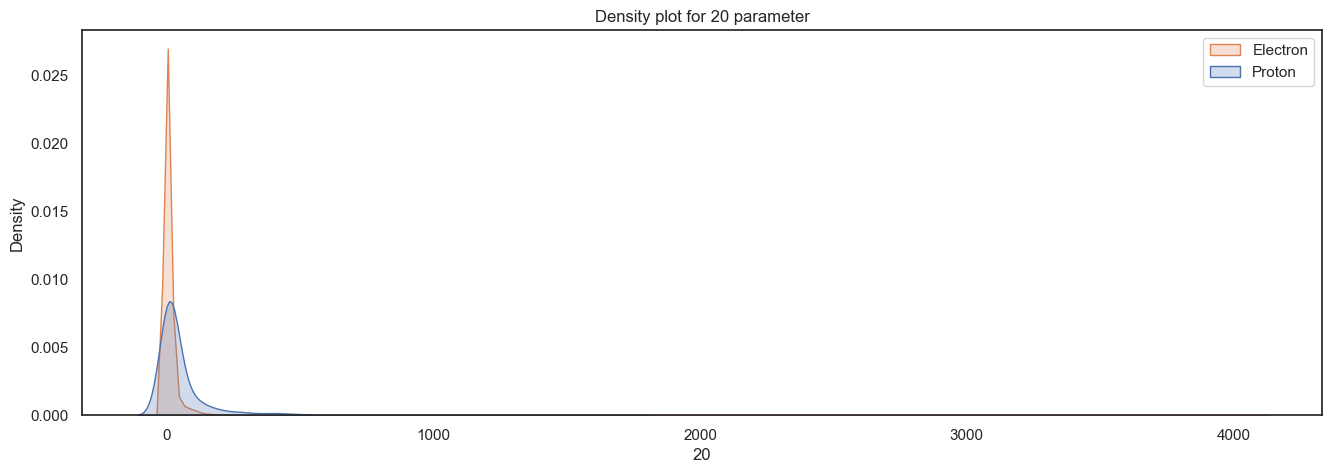

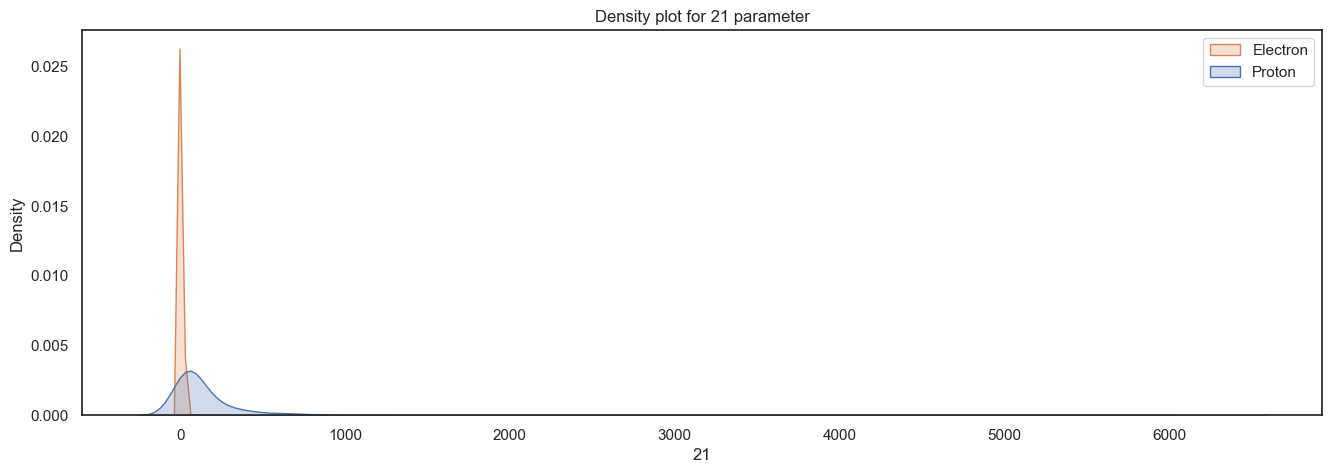

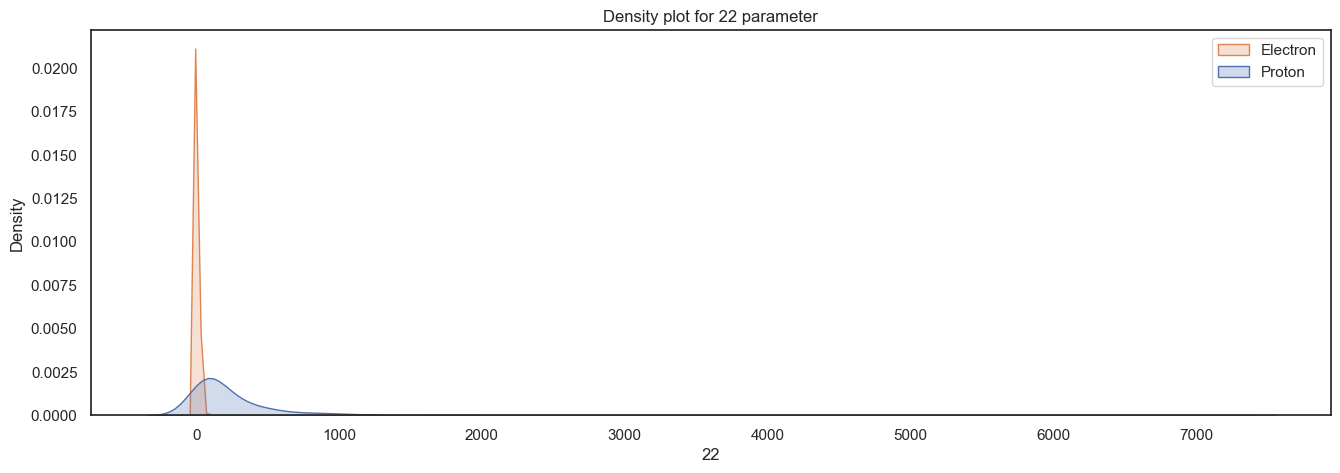

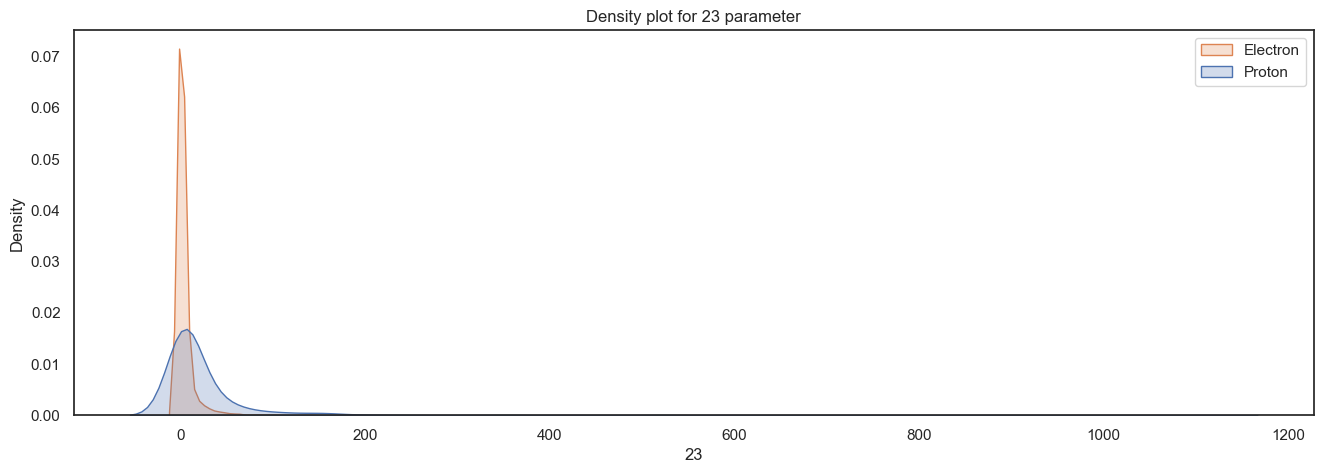

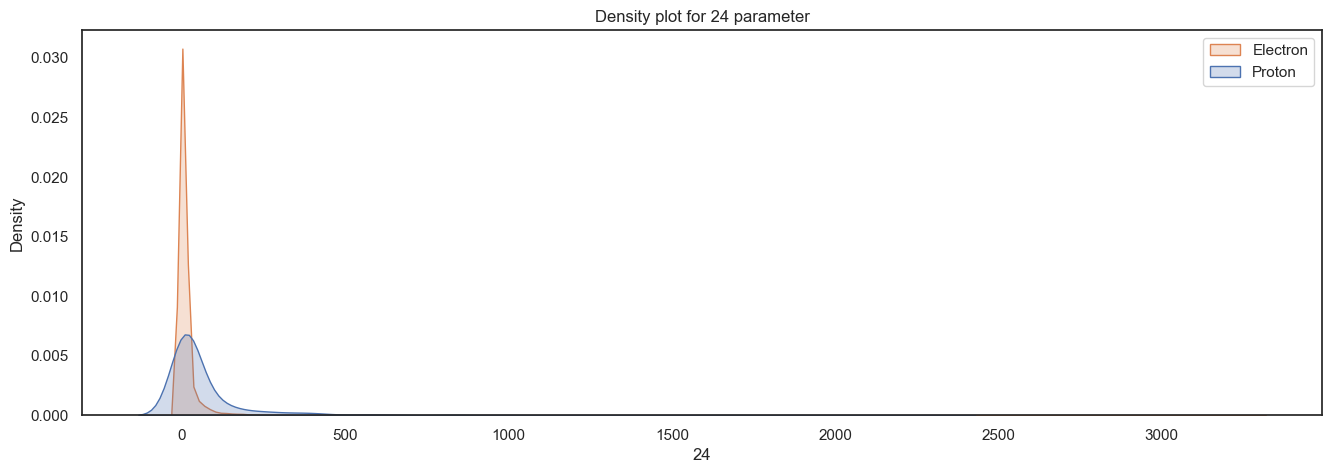

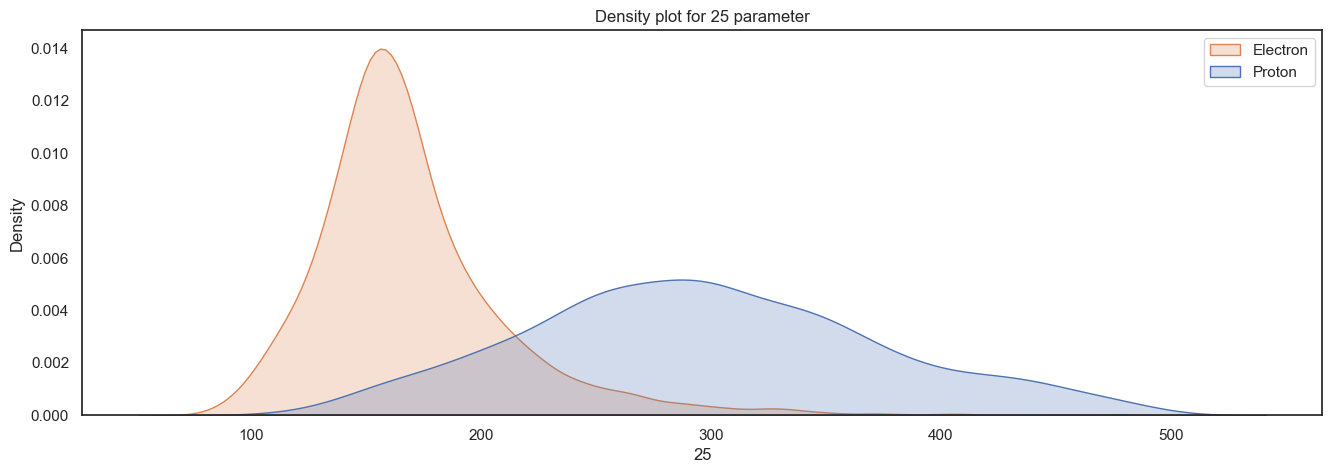

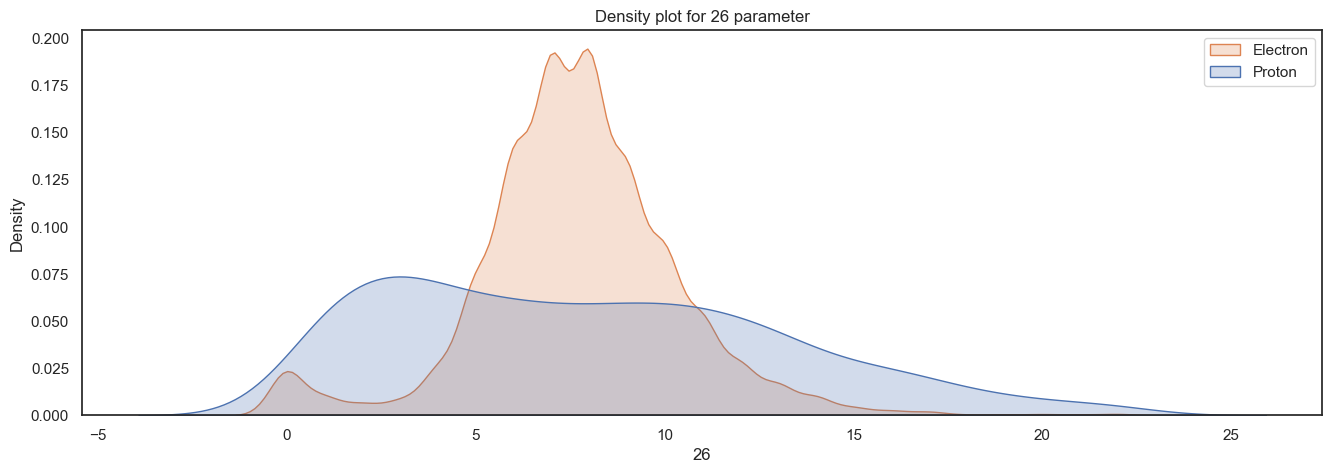

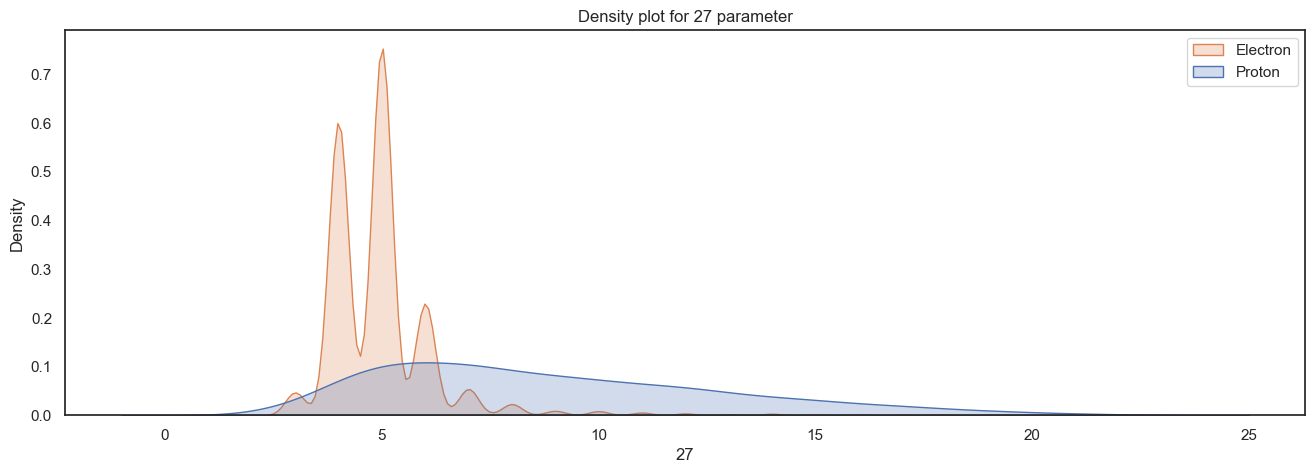

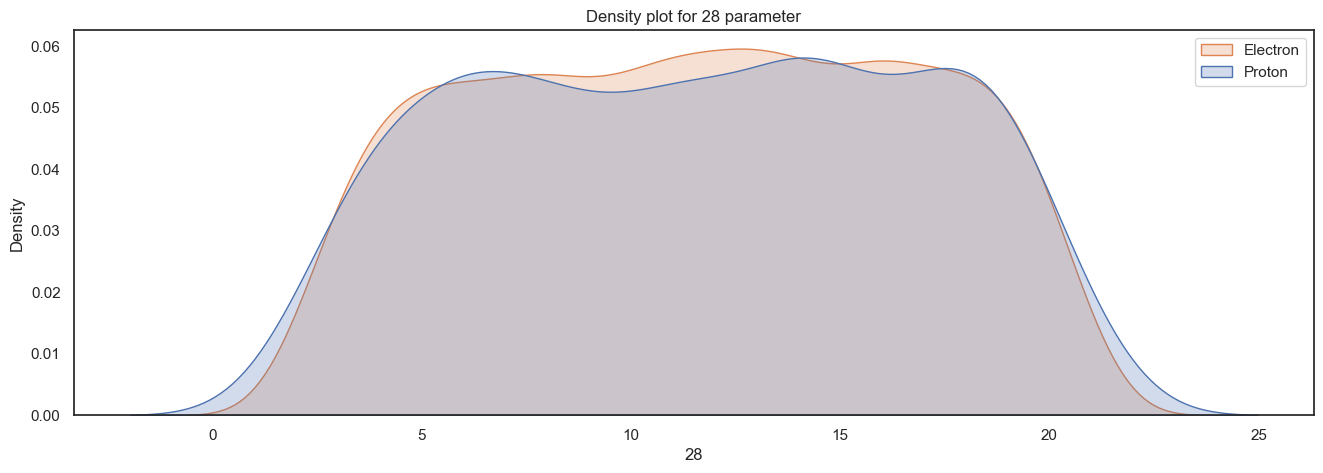

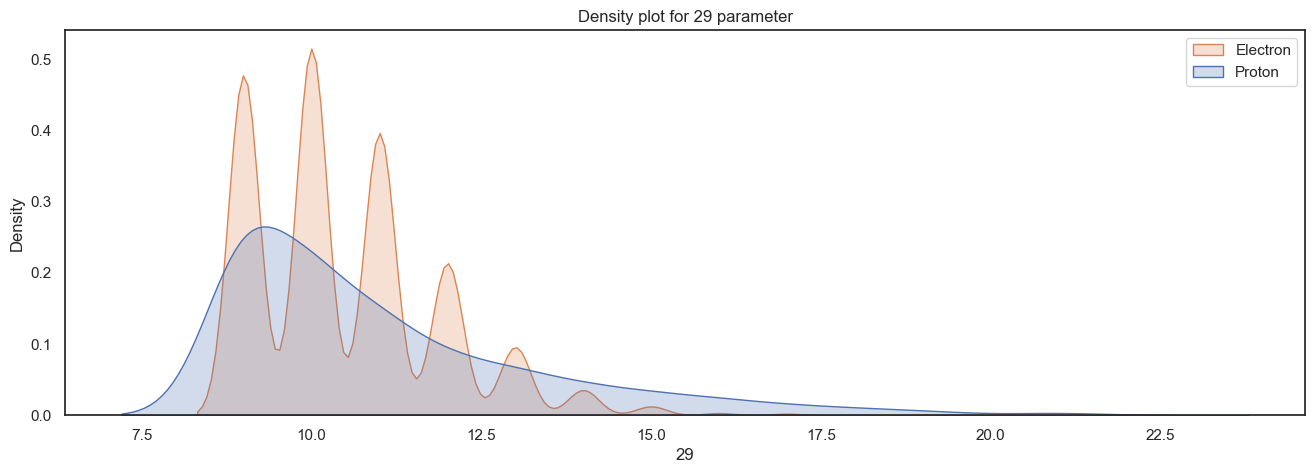

In [135]:
for i in df.columns[:-1]:
    fig = plt.subplots(figsize=(16, 5))
    var_df = df[[i, 'Label']]
    sns.kdeplot(data=var_df, x= i, hue='Label', common_norm=False, fill=True)

    plt.xlabel(i)
    plt.ylabel('Density')
    plt.title(f'Density plot for {i} parameter')
    plt.legend(['Electron', 'Proton'])

    plt.show()

# SEARCH WITHOUT REGULISATION

In [35]:
input_data_names = [
    "",
    "cutted"
]
standard_names = [
    "",
    "standard"
]
reduce_names = [
    "",
    "pca",
    "umap"
]
classificator_names = [
    "knn",
    "logreg",
    "tree",
    "forest"
]

pipeline_dict = {
    "standard" : ('standard', StandardScaler()),
    "pca" : ('pca', PCA(n_components=16)),
    "umap" : ('umap', UMAP(n_components=16)),
    "knn" : ('knn', KNeighborsClassifier()),
    "logreg" : ('logreg', LogisticRegression(max_iter=1000000, solver='sag')),
    "tree" : ('tree', DecisionTreeClassifier()),
    "forest" : ('forest', RandomForestClassifier())
}

param_grids = {
    "knn" : {
        'knn__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        },
    "logreg" : {
        'logreg__C' : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
        },
    "tree" : {
       'tree__max_depth' : [1, 2, 3, 4, 5]
    },
    "forest" : {
        'forest__max_depth' : [1, 2, 3, 4, 5]
    }
}

param_names = {
    "knn" : 'knn__n_neighbors',
    "logreg" : 'logreg__C',
    "tree" : 'tree__max_depth',
    "forest" : 'forest__max_depth' 
}

# def mean_k_fold(dictionary):
#     keyList = list(dictionary.keys())
#     for key in keyList:
#         if key == 'params':
#             continue
#         dictionary[key + ' all'] = dictionary[key]
#         dictionary[key] = np.mean(dictionary[key])
#     return dictionary

In [199]:
scorer = make_scorer(f1_score)

result_dict_BAD = {}

for input_data_name in input_data_names:
    for standard_name in standard_names:
        for reduce_name in reduce_names:
            for classificator_name in classificator_names:
                if (standard_name == "" and (reduce_name == "pca" or reduce_name == "umap")):
                    continue
                name_test = input_data_name + " " \
                    + standard_name + " " \
                    + reduce_name + " " \
                    + classificator_name
                print(name_test + " start")
                if input_data_name != "":
                    XX = X_train_cutted
                    XX_test = X_test_cutted
                else:
                    XX = X_train
                    XX_test = X_test
                pipeline_constructor = []
                if standard_name != "":
                    pipeline_constructor.append(
                        pipeline_dict[standard_name]
                    )
                if reduce_name != "":
                    pipeline_constructor.append(
                        pipeline_dict[reduce_name]
                    )
                pipeline_constructor.append(
                    pipeline_dict[classificator_name]
                )


                pipeline = Pipeline(pipeline_constructor)
                model = pipeline
                model.fit(XX, y_train)
                model_metrics = {}
                model_predict = model.predict(XX_test)
                model_predict_proba = model.predict_proba(XX_test)
                model_metrics["accuracy"] = accuracy_score(y_true=y_test, y_pred=model_predict)
                model_metrics["f1"] = f1_score(y_true=y_test, y_pred=model_predict)
                model_metrics["precision"] = precision_score(y_true=y_test, y_pred=model_predict)
                model_metrics["regection"] = precision_score(y_true=y_test, y_pred=model_predict, pos_label=0)
                model_metrics["recall"] = recall_score(y_true=y_test, y_pred=model_predict)
                model_metrics["roc_auc"] = roc_auc_score(y_true=y_test, y_score=model_predict_proba[:,1])
                result_dict_BAD[name_test] = model_metrics

                print(XX.shape)
                print(model)
                print(name_test + "  done")
                

                




   knn start
(7120, 30)
Pipeline(steps=[('knn', KNeighborsClassifier())])
   knn  done
   logreg start
(7120, 30)
Pipeline(steps=[('logreg', LogisticRegression(max_iter=1000000, solver='sag'))])
   logreg  done
   tree start
(7120, 30)
Pipeline(steps=[('tree', DecisionTreeClassifier())])
   tree  done
   forest start
(7120, 30)
Pipeline(steps=[('forest', RandomForestClassifier())])
   forest  done
 standard  knn start
(7120, 30)
Pipeline(steps=[('standard', StandardScaler()),
                ('knn', KNeighborsClassifier())])
 standard  knn  done
 standard  logreg start
(7120, 30)
Pipeline(steps=[('standard', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000000, solver='sag'))])
 standard  logreg  done
 standard  tree start
(7120, 30)
Pipeline(steps=[('standard', StandardScaler()),
                ('tree', DecisionTreeClassifier())])
 standard  tree  done
 standard  forest start
(7120, 30)
Pipeline(steps=[('standard', StandardScaler()),
                ('for

/Users/snow0w/mephi/diplom/repo/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(7120, 26)
Pipeline(steps=[('logreg', LogisticRegression(max_iter=1000000, solver='sag'))])
cutted   logreg  done
cutted   tree start
(7120, 26)
Pipeline(steps=[('tree', DecisionTreeClassifier())])
cutted   tree  done
cutted   forest start
(7120, 26)
Pipeline(steps=[('forest', RandomForestClassifier())])
cutted   forest  done
cutted standard  knn start
(7120, 26)
Pipeline(steps=[('standard', StandardScaler()),
                ('knn', KNeighborsClassifier())])
cutted standard  knn  done
cutted standard  logreg start


/Users/snow0w/mephi/diplom/repo/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(7120, 26)
Pipeline(steps=[('standard', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000000, solver='sag'))])
cutted standard  logreg  done
cutted standard  tree start
(7120, 26)
Pipeline(steps=[('standard', StandardScaler()),
                ('tree', DecisionTreeClassifier())])
cutted standard  tree  done
cutted standard  forest start
(7120, 26)
Pipeline(steps=[('standard', StandardScaler()),
                ('forest', RandomForestClassifier())])
cutted standard  forest  done
cutted standard pca knn start
(7120, 26)
Pipeline(steps=[('standard', StandardScaler()), ('pca', PCA(n_components=16)),
                ('knn', KNeighborsClassifier())])
cutted standard pca knn  done
cutted standard pca logreg start


/Users/snow0w/mephi/diplom/repo/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(7120, 26)
Pipeline(steps=[('standard', StandardScaler()), ('pca', PCA(n_components=16)),
                ('logreg', LogisticRegression(max_iter=1000000, solver='sag'))])
cutted standard pca logreg  done
cutted standard pca tree start
(7120, 26)
Pipeline(steps=[('standard', StandardScaler()), ('pca', PCA(n_components=16)),
                ('tree', DecisionTreeClassifier())])
cutted standard pca tree  done
cutted standard pca forest start
(7120, 26)
Pipeline(steps=[('standard', StandardScaler()), ('pca', PCA(n_components=16)),
                ('forest', RandomForestClassifier())])
cutted standard pca forest  done
cutted standard umap knn start
(7120, 26)
Pipeline(steps=[('standard', StandardScaler()),
                ('umap',
                 UMAP(n_components=16, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('knn', KNeighborsClassifier())])
cutted standard umap knn  done
cut

In [200]:
result_metrics_df_BAD = pd.DataFrame()
res_var_df = []
for key in result_dict_BAD:
    res_var_df = pd.DataFrame.from_dict([result_dict_BAD[key]])
    res_var_df.index = [key]
    result_metrics_df_BAD = pd.concat([result_metrics_df_BAD, res_var_df])
result_metrics_df_BAD.sort_values(by=["f1", "roc_auc"], inplace=True, ascending=False)


In [38]:
result_metrics_df_BAD.to_csv("BAD2.csv", encoding='utf-8')

# [TEST MODEL BAD]

In [29]:
test_model = Pipeline([
    # ('pca', PCA(n_components=16)),
    ('knn', KNeighborsClassifier())
])
test_model.fit(X_train_cutted, y_train)
pred = test_model.predict(X_test_cutted)
# pred = test_model.predict(X_test_cutted)
f1_score(y_true=y_test, y_pred=pred)
# f1_score(y_true=y_test, y_pred=pred)
# print(test_model)

0.8746518105849581

# TEST names features

In [54]:
names = ["RMS_22", "Esum22", "EnGrow", "Emax_track", "EsumCC2", "sum01", "sum02",
 "sum03", "EmaxСС2", "E3_track", "E_track", "RMS_1", "RMS_max", "Esum_S4",
  "Emax_S4", "Esum_S3", "Emax_S3", "Emax_left_BDK", "Esum_left_BDK", "Emax_front_BDK",
   "Esum_front_BDK", "Emax_right_BDK", "Esum_right_BDK", "Emax_back_BDK", "Esum_back_BDK",
    "hitsum", "hit1", "transversal", "longitudinal", "Number_points_track", "Label"]

prot = pd.read_csv('./data/proton.txt', delimiter='\s+', header=None)
elec = pd.read_csv('./data/electron.txt', delimiter='\s+', header=None)
# prot['Label'] = 0
# elec['Label'] = 1
prot['Label'] = 1
elec['Label'] = 0
df = pd.concat([prot, elec], ignore_index=True)
# drop columns with observation number 
df.drop(columns=30, inplace=True)
# df.head(5)
# print(f'df {len(df.columns)}, names {len(test)}')
df.set_axis(test, axis=1)


RMS_22       Esum22        EnGrow    Emax_track       EsumCC2  \
0     1.681687e+00  2442.172922   1466.325195   7331.625977   99156.11716   
1     4.726171e+00   993.728749    624.011231   4368.078613   93486.59595   
2     2.574218e+00  5301.873613   7335.816895  29343.267580  257374.10180   
3     2.149558e+00    65.129193   1543.478516   9260.871094   88225.22611   
4     1.560035e+00  7015.550550   8678.171875  34712.687500  277539.01790   
...            ...          ...           ...           ...           ...   
8895  4.850554e-07     7.864458  14264.954100  57059.816410  444409.09500   
8896  0.000000e+00     5.584425  10933.917970  54669.589840  370873.01960   
8897  0.000000e+00     0.000000   8801.856771  26405.570310  143331.58870   
8898  0.000000e+00     0.000000   5805.968099  17417.904300  113086.63410   
8899  0.000000e+00     0.000000   9012.600911  27037.802730  148091.48290   

            sum01         sum02         sum03       EmaxСС2      E3_track  \
0       52.097996     92.443881    122.851806   7331.625977   63233.28342   
1      187.964005   1768.077230   5375.468752   4368.078613   61367.27755   
2       27.923212     76.730378    104.166392  29343.267580  211599.96660   
3       69.721234     97.985979    154.712729   9260.871094   77941.39952   
4       64.527307    110.758855    146.482689  34712.687500  227888.63240   
...           ...           ...           ...           ...           ...   
8895  2437.889232  21325.891910  59398.416000  57059.816410  410110.27500   
8896  1910.832434  16133.776250  38716.067720  54669.589840  343712.90080   
8897   183.442407   1609.862082   7206.797953  26405.570310  134326.42050   
8898   591.402736   3803.385661  11496.631030  17417.904300  106120.70250   
8899  1199.503205  12958.274690  29210.053560  27037.802730  137624.67740   

      ...  Emax_right_BDK  Esum_right_BDK  Emax_back_BDK  Esum_back_BDK  \
0     ...       60.957237      120.812424      12.724501      43.514760   
1     ...       80.545142      117.862353       1.265874       6.076198   
2     ...      242.316949      449.656457      24.371688      49.259822   
3     ...        4.362726        9.818884     118.839809     250.841760   
4     ...      306.907258      475.765952       8.148394      34.616762   
...   ...             ...             ...            ...            ...   
8895  ...        0.098967        0.265239      15.477099      46.947701   
8896  ...        1.340039        1.409547       0.282425       5.349049   
8897  ...        0.000000        0.002598       2.565083       6.317821   
8898  ...        0.000000        0.000000       0.452615       1.216597   
8899  ...        0.072449        0.123428       0.020950       0.032412   

      hitsum  hit1  transversal  longitudinal  Number_points_track  Label  
0        240     3           11            17                    9      1  
1        336     8            8            11                   16      1  
2        329     3           11            16                   12      1  
3        218     6           13            20                   10      1  
4        288     4           12            17                   10      1  
...      ...   ...          ...           ...                  ...    ...  
8895     200    12            5            15                    9      0  
8896     227    10            6             9                   10      0  
8897     164     7            5            16                   10      0  
8898     151     6            4            17                   10      0  
8899     167    11            4             6                    9      0  

[8900 rows x 31 columns]

# Table bad2 format

In [194]:
bad2 = pd.read_csv('BAD2.csv')
# bad2 = bad2.applymap(lambda x: f"{x:0.2f}")

bad2['accuracy'] = bad2['accuracy'].apply(lambda x: f"{x:0.5f}")
bad2['f1'] = bad2['f1'].apply(lambda x: f"{x:0.5f}")
bad2['precision'] = bad2['precision'].apply(lambda x: f"{x:0.5f}")
bad2['recall'] = bad2['recall'].apply(lambda x: f"{x:0.5f}")
bad2.to_csv("bad3.csv", encoding='utf-8')